In [ ]:
# Acknolwledgement: referencing Stackoverflow.com and chatgpt in data interrpretability and code debugging 

In [1]:
# Importing Libraries
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from transformers import ViTImageProcessor, AutoModel
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from ultralytics import YOLO
import torch
import torch.nn.functional as F

2024-12-09 17:13:19.361455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 17:13:20.122905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [4]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
#from matplotlib import pyplot as plt
from tqdm import tqdm  # For progress bars

In [5]:
ls

best_model.h5
best_model_history.json
dish_ids/
Glycemic_Index_Table.csv
imagery/
metadata/
Nutritional_Values_Nutrition5k_Images.ipynb
README
resnet50_nutrition_labels.pth
scripts/
transformer_nutrition_model.h5
Untitled1.ipynb
Untitled.ipynb
updated_glycemic_index_table_with_gi.csv
yolov8s.pt
yolov8_tf_nutrition_model.h5


# Data Exploration

In [6]:
# we set the paths of the imagery files and subset from the metadata folder, dish_metadata_cafe1.csv
imagery_path = 'imagery/realsense_overhead'
metadata_path = 'metadata/dish_metadata_cafe1.csv'

In [7]:
# we choose to use the first six features of the columns
df_labels = pd.read_csv(metadata_path, usecols=[0, 1, 2, 3, 4, 5])

In [8]:
print(df_labels.head(20))

    dish_1561662216   300.794281  193.000000  12.387489  28.218290  18.633970
0   dish_1562688426   137.569992        88.0   8.256000   5.190000  10.297000
1   dish_1561662054   419.438782       292.0  23.838249  26.351543  25.910593
2   dish_1562008979   382.936646       290.0  22.224644  10.173570  35.345387
3   dish_1560455030    20.590000       103.0   0.148000   4.625000   0.956000
4   dish_1558372433    74.360001       143.0   0.286000   0.429000  20.020000
5   dish_1563379132   232.050003       119.0  14.280000  14.280000  10.591001
6   dish_1565640549    45.482903       139.0   1.568471   7.043886   2.641478
7   dish_1563207364   309.269989       271.0  13.774000  30.657000  15.010000
8   dish_1561575474   120.058434       183.0   4.966118  17.412746   2.990431
9   dish_1550795690    68.119995       131.0   0.262000  18.340000   0.393000
10  dish_1563216717   246.007996       332.0   5.636517  16.284782  33.068710
11  dish_1565972591   195.199997       122.0  12.200000   3.6600

In [9]:
print(df_labels.shape)

(4767, 6)


## We add the column names of the first six columns, from the readme of the Nutrition5k 
## https://github.com/google-research-datasets/Nutrition5k
## ['dish_id', 'total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein']
## choosing to focus our exploration towards the identification of the nutritional facts 
## of the corresponding images of dishes with corresponding dish_id in the metadata.
## knowing the nutritionnal facts, and the caloric category of the meal  would be of great help in meal choice.

In [10]:
df_labels.columns = ['dish_id', 'total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein']

In [11]:
print(df_labels.head())

           dish_id  total_calories  total_mass  total_fat  total_carb  \
0  dish_1562688426      137.569992        88.0   8.256000    5.190000   
1  dish_1561662054      419.438782       292.0  23.838249   26.351543   
2  dish_1562008979      382.936646       290.0  22.224644   10.173570   
3  dish_1560455030       20.590000       103.0   0.148000    4.625000   
4  dish_1558372433       74.360001       143.0   0.286000    0.429000   

   total_protein  
0      10.297000  
1      25.910593  
2      35.345387  
3       0.956000  
4      20.020000  


In [12]:
# we check if there are missing values
print('missing values per column:')
print(df_labels.isna().sum())

missing values per column:
dish_id           0
total_calories    0
total_mass        0
total_fat         0
total_carb        0
total_protein     0
dtype: int64


In [13]:
# we print some stats of the metadata
print('summary stats')
print(df_labels.describe())

summary stats
       total_calories   total_mass    total_fat   total_carb  total_protein
count     4767.000000  4767.000000  4767.000000  4767.000000    4767.000000
mean       223.964721   191.429411    11.256530    17.849535      15.198373
std        312.614376   275.075781    24.940920    29.131571      18.730203
min          0.000000     1.000000     0.000000     0.000000       0.000000
25%         60.935841    72.000000     0.616000     5.120000       1.679947
50%        154.279999   145.000000     6.483000    12.712000       8.259001
75%        324.397980   260.000000    16.066000    24.200001      22.504988
max       9485.815430  7975.000000   875.541016   844.568604     147.491821


# Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

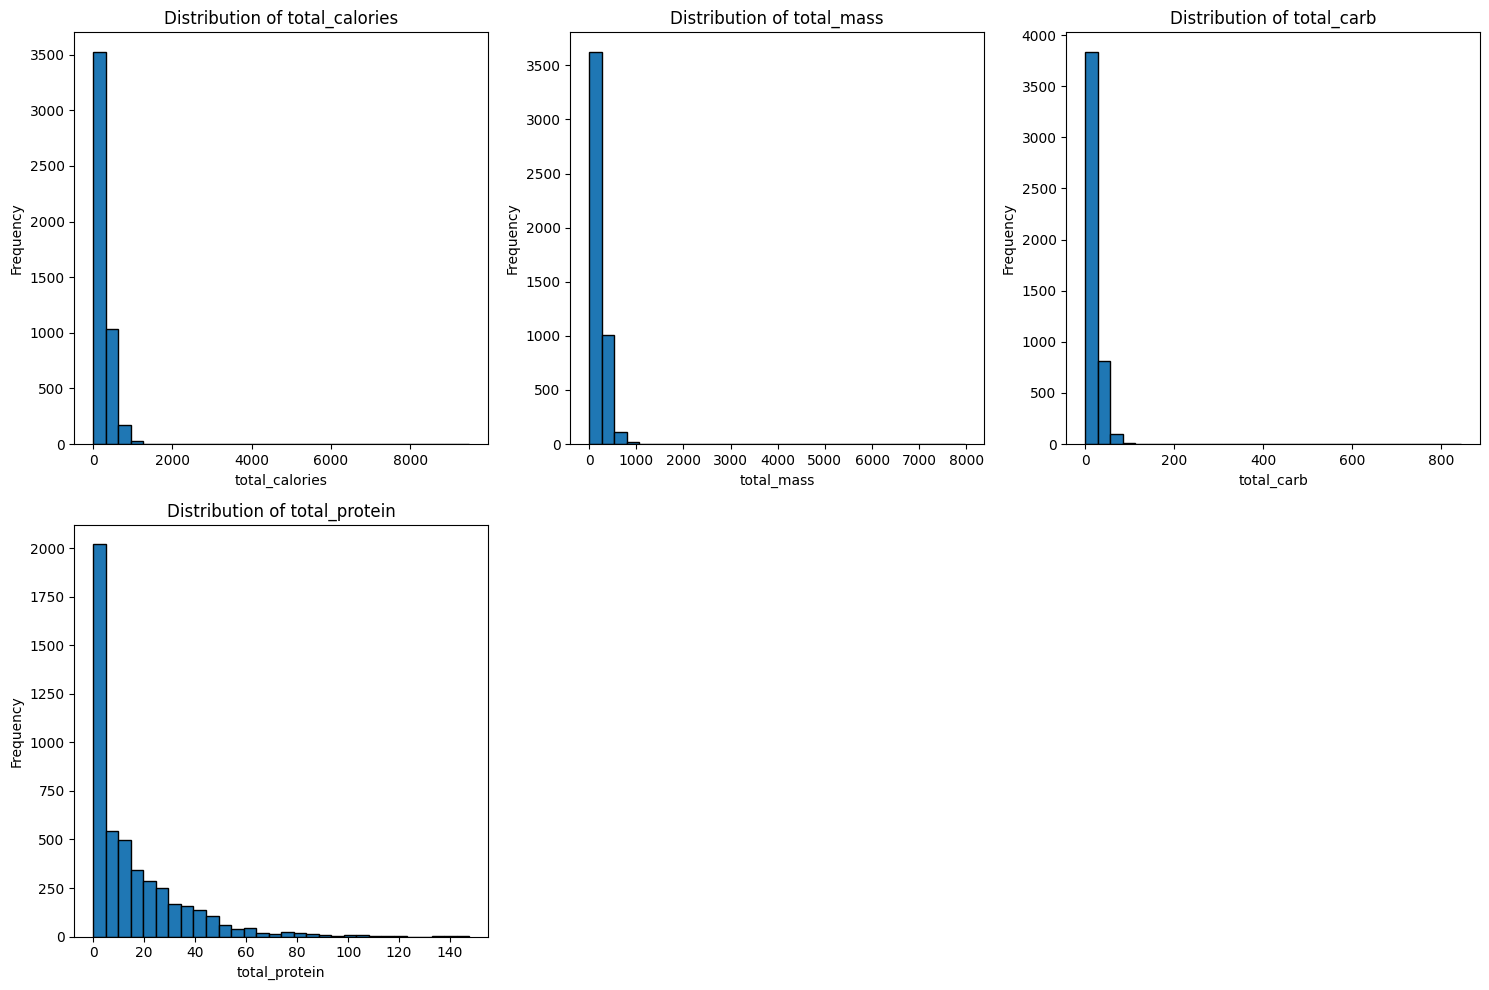

In [14]:
# We create a for loop to plot histograms for the distribution of each fearute

plt.figure(figsize=(15, 10))

for i, column in enumerate(['total_calories', 'total_mass', 'total_carb', 'total_protein'], 1):
    plt.subplot(2, 3, i)
    plt.hist(df_labels[column], bins=30, edgecolor='k')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

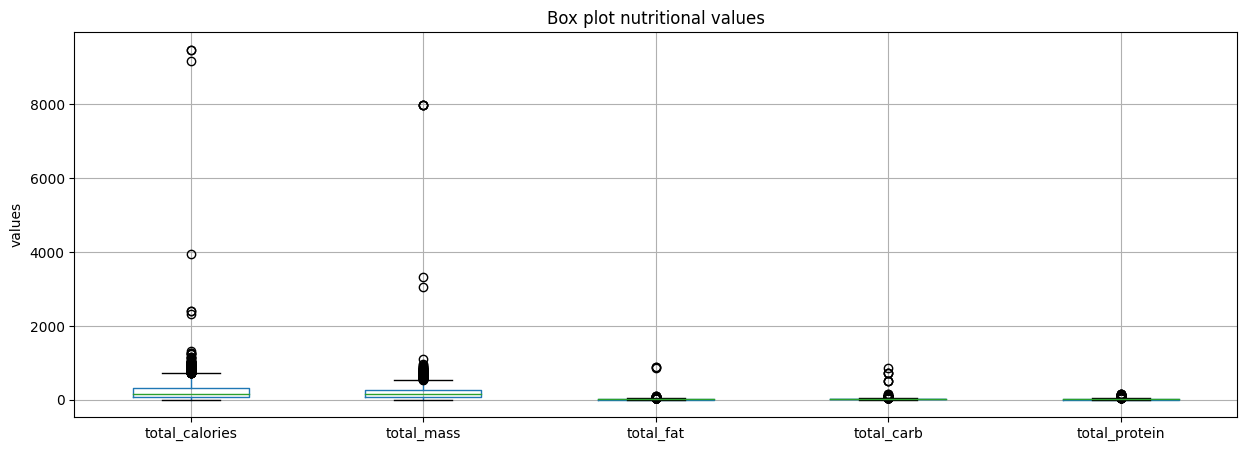

In [15]:
# we use a box plot ot all nutritional values
plt.figure(figsize=(15, 5))
df_labels[['total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein']].boxplot()
plt.title('Box plot nutritional values')
plt.ylabel('values')
plt.show

In [16]:
# we create a correlation matrix to the different features
correlation_matrix = df_labels[['total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein']].corr()
print(correlation_matrix)


                total_calories  total_mass  total_fat  total_carb  \
total_calories        1.000000    0.484853   0.920773    0.681952   
total_mass            0.484853    1.000000   0.332770    0.490518   
total_fat             0.920773    0.332770   1.000000    0.456154   
total_carb            0.681952    0.490518   0.456154    1.000000   
total_protein         0.622438    0.432019   0.410218    0.283299   

                total_protein  
total_calories       0.622438  
total_mass           0.432019  
total_fat            0.410218  
total_carb           0.283299  
total_protein        1.000000  


<function matplotlib.pyplot.show(close=None, block=None)>

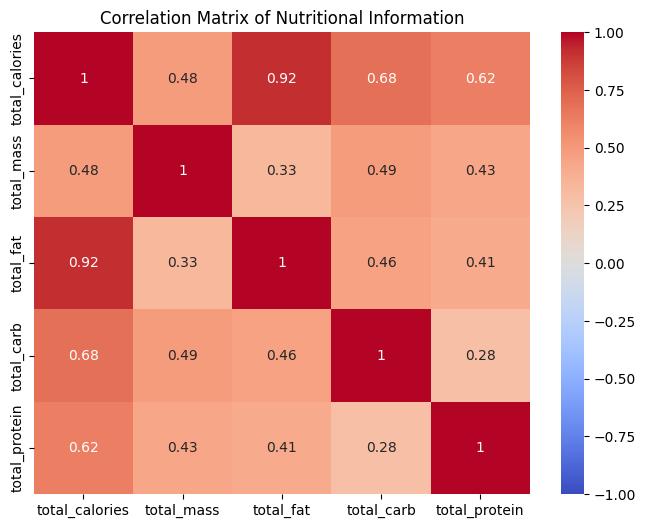

In [17]:
# we create a correlation heatmap for better visualization of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Nutritional Information')
plt.show

# Feature Engineering

In [18]:
#  we categorize the 'total_calories' feature( which is continuous data)
# into bins labeled(low, medium and high) inside a new column 'calorie_category'
df_labels['calorie_category'] = pd.cut(
    df_labels['total_calories'],
    bins=[0, 200, 500, float('inf')],
    labels=['Low', 'Medium', 'High'])



In [19]:
df_labels.head()

dish_id  total_calories  total_mass  total_fat  total_carb  \
0  dish_1562688426      137.569992        88.0   8.256000    5.190000   
1  dish_1561662054      419.438782       292.0  23.838249   26.351543   
2  dish_1562008979      382.936646       290.0  22.224644   10.173570   
3  dish_1560455030       20.590000       103.0   0.148000    4.625000   
4  dish_1558372433       74.360001       143.0   0.286000    0.429000   

   total_protein calorie_category  
0      10.297000              Low  
1      25.910593           Medium  
2      35.345387           Medium  
3       0.956000              Low  
4      20.020000              Low

/tmp/ipykernel_2945/723807228.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='calorie_category', data=df_labels, palette=palette)


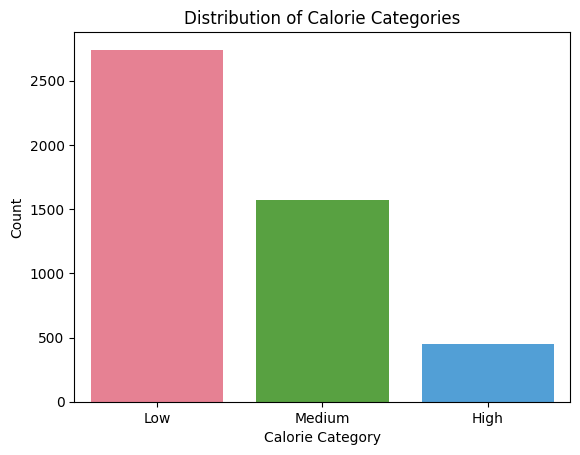

In [20]:
# we plot the distribution of the different calorie categories
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette("husl", n_colors=df_labels['calorie_category'].nunique())

sns.countplot(x='calorie_category', data=df_labels, palette=palette)
plt.title('Distribution of Calorie Categories')
plt.xlabel('Calorie Category')
plt.ylabel('Count')
plt.show()

# More feature Engineering

## Since the Glycemic Index is an improtant factor, in addition to carbs, in predicting a patient's post-brandial blood glucose values
##  The Nutiriton5k dataset doesn't have the GI as a feature so we had to come up with an approach to augment it.
## We created a dataset with a list different foods avaiable on the web with the total mass, fiber content, fat content, carb content and GI values. 
## We use the GI table to train a model to predict GI values from the remaining features 
## then use this model and apply it to the nutrition5k to predict GI values,  augmenting the dataset with a new engineered GI feature.

In [21]:
#GI_path = r'C:\Users\dinas\Downloads\trimmed_glycemic_index_50_foods.csv'
GI_path = 'Glycemic_Index_Table.csv'

In [22]:
df_GI =  pd.read_csv(GI_path)
df_GI.head()

Foods  GI  Total Mass (g)  Total Carbs (g)  Total Fat (g)  \
0            Apple  36             150               14            0.2   
1      Apple juice  41             250               28            0.1   
2           Banana  51             118               27            0.3   
3           Barley  28             100               22            1.0   
4  Carrots, boiled  39              80                7            0.1   

   Total Protein (g)  
0                0.3  
1                0.1  
2                1.3  
3                2.3  
4                0.2

In [23]:
df_GI.rename(columns={"Foods": "Foods", "GI": "GI", "Total Mass (g)": "total_mass", "Total Carbs (g)": "total_carb", "Total Fat (g)": "total_fat", "Total Protein (g)": "total_protein"}, inplace=True)

In [24]:
df_GI.head()

Foods  GI  total_mass  total_carb  total_fat  total_protein
0            Apple  36         150          14        0.2            0.3
1      Apple juice  41         250          28        0.1            0.1
2           Banana  51         118          27        0.3            1.3
3           Barley  28         100          22        1.0            2.3
4  Carrots, boiled  39          80           7        0.1            0.2

In [25]:
print(df_GI.shape)

(53, 6)


In [26]:
# we split the data to labels(X) and target(y)
X = df_GI[['total_carb', 'total_fat', 'total_protein', 'total_mass']]
y = df_GI['GI']

In [27]:
X.head()

total_carb  total_fat  total_protein  total_mass
0          14        0.2            0.3         150
1          28        0.1            0.1         250
2          27        0.3            1.3         118
3          22        1.0            2.3         100
4           7        0.1            0.2          80

In [28]:
y.head()

0    36
1    41
2    51
3    28
4    39
Name: GI, dtype: int64

In [29]:
# we split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# we convert the target to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [31]:
#  then we define a fully connected neural network

GI_model = Sequential([
    Dense(20, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer
    Dense(10, activation='relu'),  # Second hidden layer
    Dense(1)  # Output layer
])

#  then compile the model
GI_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

2024-12-09 17:14:57.181917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-09 17:14:57.197721: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [32]:
# we train the model
history = GI_model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2, verbose=1)

Epoch 1/100
4/4 [==============================] - 0s 36ms/step - loss: 10349.8516 - mae: 99.1669 - val_loss: 9595.4014 - val_mae: 94.4657
Epoch 2/100
4/4 [==============================] - 0s 6ms/step - loss: 9708.7051 - mae: 96.0545 - val_loss: 8990.6777 - val_mae: 91.4918
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 9056.5381 - mae: 92.8376 - val_loss: 8413.4014 - val_mae: 88.5390
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 8452.0244 - mae: 89.6829 - val_loss: 7854.8208 - val_mae: 85.5609
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 7789.6191 - mae: 86.2848 - val_loss: 7345.5889 - val_mae: 82.7196
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 7265.6792 - mae: 83.2059 - val_loss: 6858.8672 - val_mae: 79.8785
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 6713.5830 - mae: 80.0456 - val_loss: 6409.0039 - val_mae: 77.1269
Epoch 8/100
4/4 [======================

In [33]:
# we evaluate the model
evaluation = GI_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {evaluation[0]} | Test MAE: {evaluation[1]}")

# And make predictions
predictions = GI_model.predict(X_test)
print("Predictions:", predictions)

1/1 [==============================] - 0s 63ms/step - loss: 454.9056 - mae: 19.2337
Test Loss: 454.9056396484375 | Test MAE: 19.23371124267578
1/1 [==============================] - 0s 46ms/step
Predictions: [[     56.902]
 [     37.784]
 [      63.89]
 [     65.671]
 [     37.424]
 [     20.662]
 [     46.515]
 [     52.925]
 [     31.805]
 [      71.96]
 [     33.233]
 [     12.975]
 [     28.341]
 [     57.085]
 [     37.542]
 [     20.391]]


## Now we apply the MLP model on the nutrition5k dataset to predict GI and augment it to the dataset labels

In [34]:
# we select  the features we will use for prediction
features = ['total_carb', 'total_mass', 'total_fat', 'total_protein']
X_new = df_labels[features]

In [35]:
# GI prediciton using the trained model
predicted_gi = GI_model.predict(X_new)

149/149 [==============================] - 0s 474us/step


In [36]:
# we then add the predicted GI values to the dataframe
df_labels['GI'] = predicted_gi

In [37]:
print(df_labels.head(20))

            dish_id  total_calories  total_mass  total_fat  total_carb  \
0   dish_1562688426      137.569992        88.0   8.256000    5.190000   
1   dish_1561662054      419.438782       292.0  23.838249   26.351543   
2   dish_1562008979      382.936646       290.0  22.224644   10.173570   
3   dish_1560455030       20.590000       103.0   0.148000    4.625000   
4   dish_1558372433       74.360001       143.0   0.286000    0.429000   
5   dish_1563379132      232.050003       119.0  14.280000   14.280000   
6   dish_1565640549       45.482903       139.0   1.568471    7.043886   
7   dish_1563207364      309.269989       271.0  13.774000   30.657000   
8   dish_1561575474      120.058434       183.0   4.966118   17.412746   
9   dish_1550795690       68.119995       131.0   0.262000   18.340000   
10  dish_1563216717      246.007996       332.0   5.636517   16.284782   
11  dish_1565972591      195.199997       122.0  12.200000    3.660000   
12  dish_1568649312       44.459999   

# Associating the images with labels

In [38]:
# we create an empty list to store the images with the corresponding updated metadata df_labels 
image_data = []

In [39]:
# we create a for loop to iterate through the imagery folders and match them with the dish_id  
for folder_name in os.listdir(imagery_path):
    folder_path = os.path.join(imagery_path, folder_name)
    
    if os.path.isdir(folder_path):
        matching_row = df_labels[df_labels['dish_id'] == folder_name]
        
        if not matching_row.empty:
            labels_info = matching_row.iloc[0].to_dict()
            
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                
                if file_name == 'rgb.png':
                    image = Image.open(file_path).convert('RGB') #we convert the image to RGB
                    
                    image_data.append({'image': image, 'label_info': labels_info})

In [40]:
len(image_data)

3261

In [41]:
image_data[1]

{'image': <PIL.Image.Image image mode=RGB size=640x480>,
 'label_info': {'dish_id': 'dish_1558461792',
  'total_calories': 331.0,
  'total_mass': 233.0,
  'total_fat': 20.195999,
  'total_carb': 34.499001,
  'total_protein': 10.543,
  'calorie_category': 'Medium',
  'GI': 46.764381408691406}}

In [42]:
# we convert the image_data into a dataframe
df_image_data = pd.DataFrame(image_data)
print(df_image_data.head())

                                               image  \
0  <PIL.Image.Image image mode=RGB size=640x480 a...   
1  <PIL.Image.Image image mode=RGB size=640x480 a...   
2  <PIL.Image.Image image mode=RGB size=640x480 a...   
3  <PIL.Image.Image image mode=RGB size=640x480 a...   
4  <PIL.Image.Image image mode=RGB size=640x480 a...   

                                          label_info  
0  {'dish_id': 'dish_1558460205', 'total_calories...  
1  {'dish_id': 'dish_1558461792', 'total_calories...  
2  {'dish_id': 'dish_1566501012', 'total_calories...  
3  {'dish_id': 'dish_1567612954', 'total_calories...  
4  {'dish_id': 'dish_1558379128', 'total_calories...  


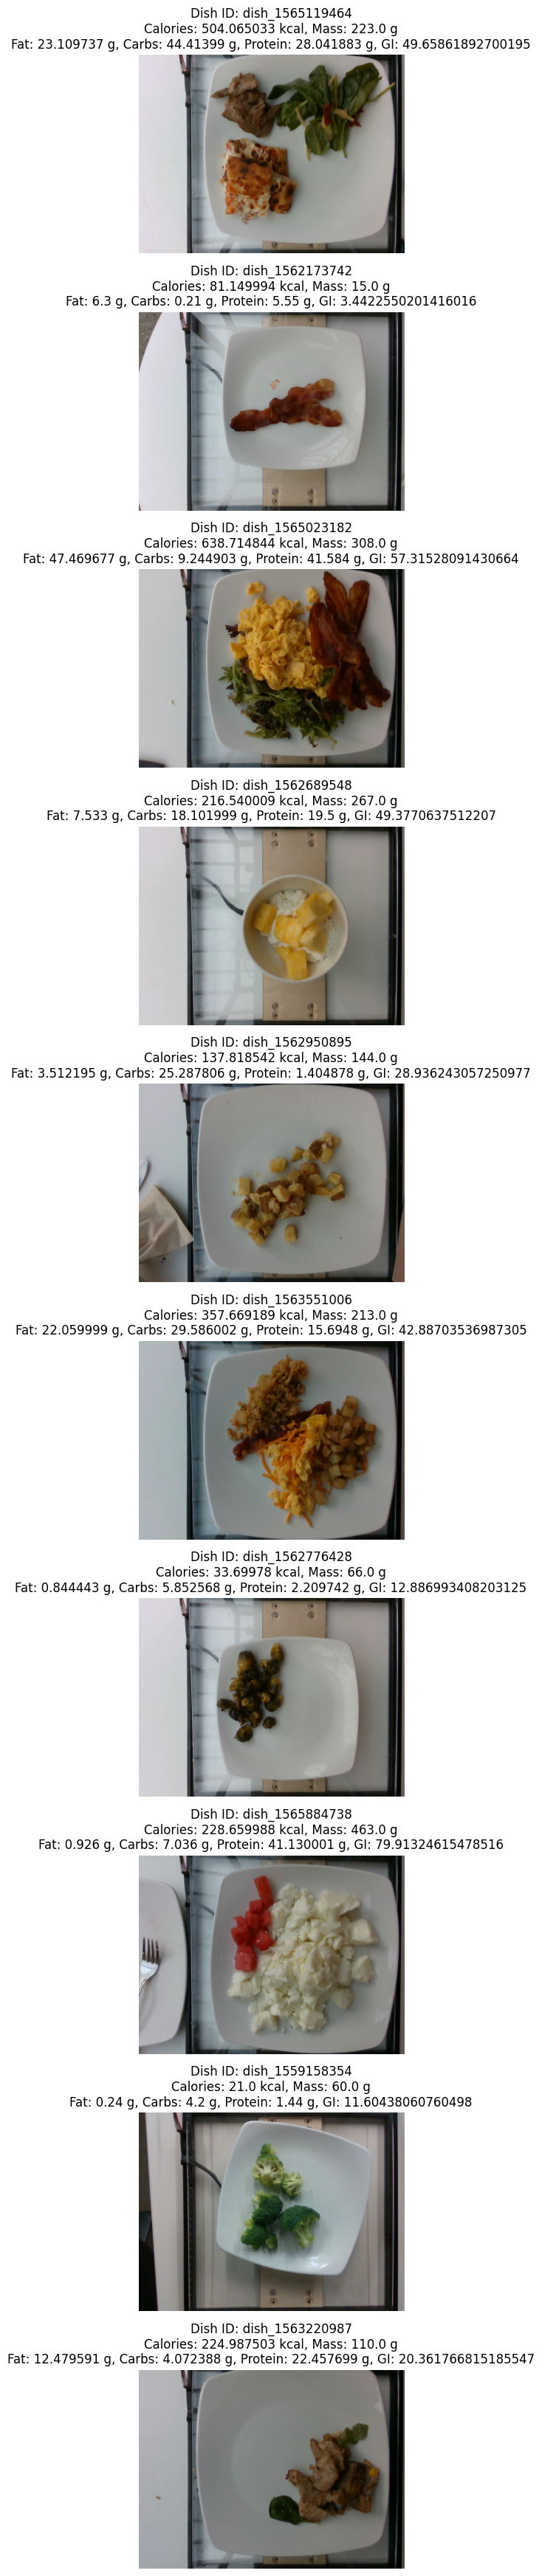

In [43]:
# we subplot to display a sample of images from df_image_data with the corresponding metadata to prove association
fig, axes = plt.subplots(10, 1, figsize=(20, 35))

# we create displayed_dishes_ids to store the sample dishes and avoid repeats

displayed_dish_ids = set()


# we create a  loop to display 10 samples 
for i in range(10):
    while True:
  
        sample_row = df_image_data.sample(1).iloc[0] # random row
        sample_dish_id = sample_row['label_info']['dish_id']
       
        
        if sample_dish_id in displayed_dish_ids:
            continue
            
        displayed_dish_ids.add(sample_dish_id)
        
        image = sample_row['image']
        label_info = sample_row['label_info']
        
        axes[i].imshow(image)
        axes[i].axis('off')
        
        title = (
             f"Dish ID: {sample_dish_id}\n"
            f"Calories: {label_info['total_calories']} kcal, "
            f"Mass: {label_info['total_mass']} g\n"
            f"Fat: {label_info['total_fat']} g, "
            f"Carbs: {label_info['total_carb']} g, "
            f"Protein: {label_info['total_protein']} g, "
            f"GI: {label_info['GI']}"
        )
        axes[i].set_title(title, fontsize=12)
        
        break
        
plt.tight_layout()
plt.show()



# YOLOv8 Model

In [44]:
# we define constants for YOLOv6 model
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 0.0001
YOLO_IMG_SIZE = 640  # the input size for YOLOv8 model
TF_IMG_SIZE = 224    # the input size for the tensorflow regression model

In [45]:
# we set the max values for the labels
max_calories = 500  # Replace with the maximum value for calories in your dataset
max_carb = 100      # Replace with the maximum value for carbs
max_gi = 100        # Replace with the maximum value for GI

# We normalize the labels
df_image_data['label_tensor'] = df_image_data['label_info'].apply(
    lambda x: [
        x['total_calories'] / max_calories,
        x['total_carb'] / max_carb,
        x['GI'] / max_gi
    ]
)

In [46]:
# we split the data into train and validation
train_df, val_df = train_test_split(df_image_data, test_size=0.1, random_state=42)

In [47]:
# we load YOLOv8 model because it is a smaller model compared to ResNet which couldn't converge
yolo_model = YOLO("yolov8s.pt") 

In [48]:
# featyre extraction function
def extract_yolo_features(image, yolo_model):
    """
    Extract features from an image using YOLOv8's backbone.
    Args:
        image: A single image as a NumPy array.
        yolo_model: The YOLOv8 model.
    Returns:
        Flattened or pooled features extracted by the YOLOv8 backbone.
    """
    # Preprocess the image for YOLOv8
    image = image.transpose(2, 0, 1)  # Convert to (C, H, W)
    image = np.ascontiguousarray(image, dtype=np.float32) / 255.0  # Normalize
    image = torch.tensor(image).unsqueeze(0)  # Add batch dimension
    
    # Run the model and extract features from the backbone
    with torch.no_grad():
        backbone_features = yolo_model.model.model[0:10](image)  # Extract intermediate features
    
    # Apply global average pooling to reduce spatial dimensions
    pooled_features = F.adaptive_avg_pool2d(backbone_features, (1, 1))  # Output shape: [batch_size, channels, 1, 1]
    return pooled_features.squeeze().numpy().flatten()  # Flatten to 1D array


In [49]:
# Preprocessing function with YOLO feature extraction
def preprocess_with_yolo(df, yolo_model, img_size=YOLO_IMG_SIZE):
    features = []
    labels = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting YOLO Features"):
        # Resize image to YOLO input size
        image = row['image'].resize((img_size, img_size))
        image = np.array(image)  # Convert PIL image to NumPy array
        yolo_features = extract_yolo_features(image, yolo_model)  # Use the updated function
        features.append(yolo_features)
        labels.append(row['label_tensor'])
    return np.array(features), np.array(labels)


In [50]:
# Plot training performance
def plot_training_performance(history):
    # Extract training history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(mae, label='Training MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.title('MAE During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.show()

In [51]:
# Use a subset of the data for quick testing
small_train_df = train_df.sample(frac=0.1, random_state=42)
small_val_df = val_df.sample(frac=0.1, random_state=42)

# Preprocess the smaller datasets
print("Preprocessing Small Train Data...")
X_train_small, y_train_small = preprocess_with_yolo(small_train_df, yolo_model)

print("Preprocessing Small Validation Data...")
X_val_small, y_val_small = preprocess_with_yolo(small_val_df, yolo_model)

Preprocessing Small Train Data...


Extracting YOLO Features: 100%|███████████████| 293/293 [00:16<00:00, 17.94it/s]


Preprocessing Small Validation Data...


Extracting YOLO Features: 100%|█████████████████| 33/33 [00:01<00:00, 17.75it/s]


In [52]:
# Build TensorFlow regression model
def build_model(input_shape, num_outputs=3):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_outputs)(x)
    return Model(inputs, outputs)

In [53]:
# Create the TensorFlow model
input_shape = X_train_small.shape[1:]  # Shape of YOLO features
model = build_model(input_shape)


In [54]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])

In [55]:
# Train the model on the subset
history = model.fit(
    X_train_small, y_train_small,
    validation_data=(X_val_small, y_val_small),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/5
37/37 [==============================] - 0s 3ms/step - loss: 0.1138 - mae: 0.2406 - val_loss: 0.0888 - val_mae: 0.2082
Epoch 2/5
37/37 [==============================] - 0s 1ms/step - loss: 0.0693 - mae: 0.1899 - val_loss: 0.0716 - val_mae: 0.1736
Epoch 3/5
37/37 [==============================] - 0s 1ms/step - loss: 0.0579 - mae: 0.1672 - val_loss: 0.0641 - val_mae: 0.1641
Epoch 4/5
37/37 [==============================] - 0s 1ms/step - loss: 0.0510 - mae: 0.1580 - val_loss: 0.0617 - val_mae: 0.1612
Epoch 5/5
37/37 [==============================] - 0s 1ms/step - loss: 0.0478 - mae: 0.1533 - val_loss: 0.0543 - val_mae: 0.1414


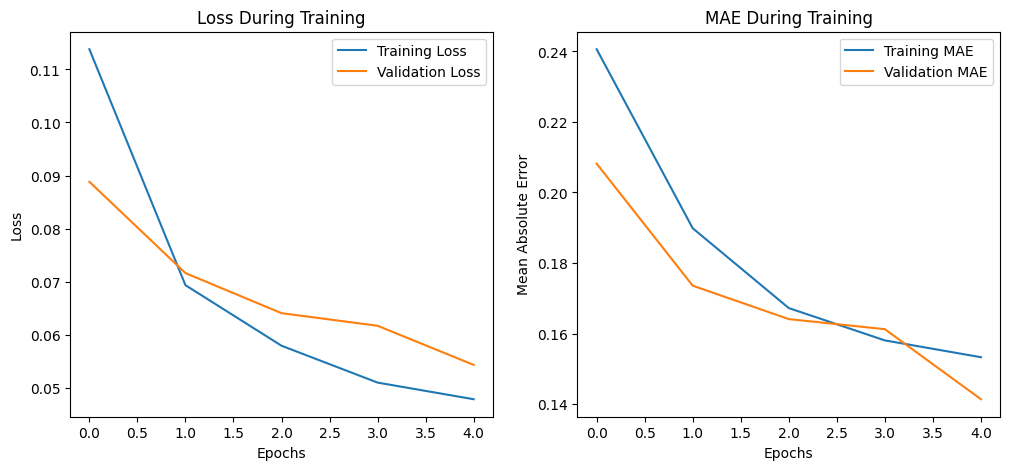

In [56]:
# Plot the training performance
plot_training_performance(history)

In [57]:
# Save the model
model.save("yolov8_tf_nutrition_model.h5")

/home/dina/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
# Predict on a single image
sample_image = small_train_df.iloc[0]['image']
sample_image = sample_image.resize((YOLO_IMG_SIZE, YOLO_IMG_SIZE))  # Resize for YOLOv8
sample_image = np.array(sample_image)

In [59]:
# Extract YOLO features for the sample image
sample_features = extract_yolo_features(sample_image, yolo_model)

In [60]:
# Predict using the trained model
sample_features = np.expand_dims(sample_features, axis=0)  # Add batch dimension
prediction = model.predict(sample_features)
print(f"Predicted Labels: {prediction[0]}")
print(f"Actual Labels: {small_train_df.iloc[0]['label_tensor']}")


1/1 [==============================] - 0s 41ms/step
Predicted Labels: [    0.82388     0.27203     0.70184]
Actual Labels: [0.8166788340000001, 0.33701878, 0.7267874908447266]


In [61]:
predicted_labels = prediction[0]
denormalized_labels = [
    predicted_labels[0] * max_calories,
    predicted_labels[1] * max_carb,
    predicted_labels[2] * max_gi
]

In [62]:

def denormalize_actual_labels(normalized_labels):
    return [
        normalized_labels[0] * max_calories,                    # Reverse normalization for calories
        normalized_labels[1] * max_carb,                        # Reverse normalization for carbs
        normalized_labels[2] * max_gi       # Reverse normalization for GI
    ]

In [63]:
# Get the normalized actual labels from the dataset
normalized_actual_labels = small_train_df.iloc[0]['label_tensor']

# Denormalize actual labels
denormalized_actual_labels = denormalize_actual_labels(normalized_actual_labels)

# Print denormalized predicted and actual labels
print(f"Denormalized Predicted Labels: {denormalized_labels}")
print(f"Denormalized Actual Labels: {denormalized_actual_labels}")

Denormalized Predicted Labels: [411.94215416908264, 27.20334231853485, 70.18443942070007]
Denormalized Actual Labels: [408.339417, 33.701878, 72.67874908447266]


# we run 10 epochs on half of the data instead of 10%

Preprocessing Small Train Data...


Extracting YOLO Features: 100%|██████████| 1467/1467 [13:57<00:00,  1.75it/s]


Preprocessing Small Validation Data...


Extracting YOLO Features: 100%|██████████| 164/164 [01:33<00:00,  1.75it/s]


Epoch 1/10
184/184 [==============================] - 0s 1ms/step - loss: 0.2873 - mae: 0.3691 - val_loss: 0.1218 - val_mae: 0.2431
Epoch 2/10
184/184 [==============================] - 0s 1ms/step - loss: 0.1126 - mae: 0.2375 - val_loss: 0.0973 - val_mae: 0.2100
Epoch 3/10
184/184 [==============================] - 0s 1ms/step - loss: 0.0839 - mae: 0.2024 - val_loss: 0.0857 - val_mae: 0.2003
Epoch 4/10
184/184 [==============================] - 0s 1ms/step - loss: 0.0744 - mae: 0.1904 - val_loss: 0.0817 - val_mae: 0.1855
Epoch 5/10
184/184 [==============================] - 0s 1ms/step - loss: 0.0637 - mae: 0.1776 - val_loss: 0.0722 - val_mae: 0.1828
Epoch 6/10
184/184 [==============================] - 0s 1ms/step - loss: 0.0639 - mae: 0.1751 - val_loss: 0.0685 - val_mae: 0.1835
Epoch 7/10
184/184 [==============================] - 0s 1ms/step - loss: 0.0619 - mae: 0.1732 - val_loss: 0.0668 - val_mae: 0.1702
Epoch 8/10
184/184 [==============================] - 0s 1ms/step - loss: 0.

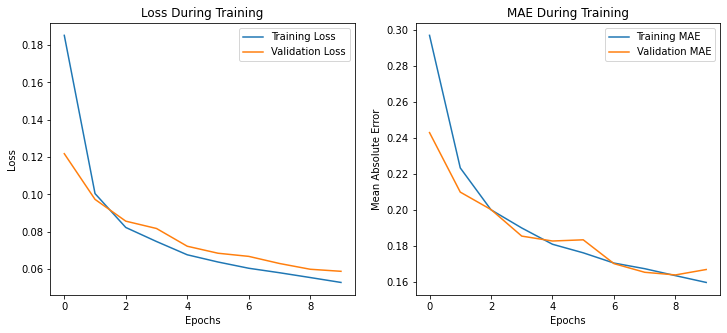

Predicted Labels: [    0.84993     0.35801      1.6467]
Actual Labels: [0.8166788340000001, 0.33701878, 1.680209197998047]
Denormalized Predicted Labels: [424.9665141105652, 35.800689458847046, 164.67368602752686]
Denormalized Actual Labels: [408.339417, 33.701878, 168.0209197998047]


In [58]:
# Constants
BATCH_SIZE = 8
EPOCHS = 10  # Reduced for quick testing
LEARNING_RATE = 0.0001
YOLO_IMG_SIZE = 640  # Input size for YOLOv8
TF_IMG_SIZE = 224    # Input size for TensorFlow regression model

# Determine max values for normalization (based on dataset statistics)
max_calories = 500  # Replace with the maximum value for calories in your dataset
max_carb = 100      # Replace with the maximum value for carbs
max_gi = 100        # Replace with the maximum value for GI

# Normalize the labels
df_image_data['label_tensor'] = df_image_data['label_info'].apply(
    lambda x: [
        x['total_calories'] / max_calories,
        x['total_carb'] / max_carb,
        x['GI'] / max_gi
    ]
)

# Split data into train and validation sets
train_df, val_df = train_test_split(df_image_data, test_size=0.1, random_state=42)

# Load YOLOv8 model
yolo_model = YOLO("yolov8s.pt")  # Small YOLOv8 model

# Feature extraction function
def extract_yolo_features(image, yolo_model):
    """
    Extract features from an image using YOLOv8's backbone.
    Args:
        image: A single image as a NumPy array.
        yolo_model: The YOLOv8 model.
    Returns:
        Flattened or pooled features extracted by the YOLOv8 backbone.
    """
    # Preprocess the image for YOLOv8
    image = image.transpose(2, 0, 1)  # Convert to (C, H, W)
    image = np.ascontiguousarray(image, dtype=np.float32) / 255.0  # Normalize
    image = torch.tensor(image).unsqueeze(0)  # Add batch dimension
    
    # Run the model and extract features from the backbone
    with torch.no_grad():
        backbone_features = yolo_model.model.model[0:10](image)  # Extract intermediate features
    
    # Apply global average pooling to reduce spatial dimensions
    pooled_features = F.adaptive_avg_pool2d(backbone_features, (1, 1))  # Output shape: [batch_size, channels, 1, 1]
    return pooled_features.squeeze().numpy().flatten()  # Flatten to 1D array

# Preprocessing function with YOLO feature extraction
def preprocess_with_yolo(df, yolo_model, img_size=YOLO_IMG_SIZE):
    features = []
    labels = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting YOLO Features"):
        # Resize image to YOLO input size
        image = row['image'].resize((img_size, img_size))
        image = np.array(image)  # Convert PIL image to NumPy array
        yolo_features = extract_yolo_features(image, yolo_model)  # Use the updated function
        features.append(yolo_features)
        labels.append(row['label_tensor'])
    return np.array(features), np.array(labels)

# Plot training performance
def plot_training_performance(history):
    # Extract training history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(mae, label='Training MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.title('MAE During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.show()

# Use 50% of the data instead of 10% of the data for quick testing
small_train_df = train_df.sample(frac=0.5, random_state=42)
small_val_df = val_df.sample(frac=0.5,  random_state=42)

# Preprocess the smaller datasets
print("Preprocessing Small Train Data...")
X_train_small, y_train_small = preprocess_with_yolo(small_train_df, yolo_model)

print("Preprocessing Small Validation Data...")
X_val_small, y_val_small = preprocess_with_yolo(small_val_df, yolo_model)

# Build TensorFlow regression model
def build_model(input_shape, num_outputs=3):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_outputs)(x)
    return Model(inputs, outputs)

# Create the TensorFlow model
input_shape = X_train_small.shape[1:]  # Shape of YOLO features
model = build_model(input_shape)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])

# Train the model on the subset
history = model.fit(
    X_train_small, y_train_small,
    validation_data=(X_val_small, y_val_small),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Plot the training performance
plot_training_performance(history)

# Save the model
model.save("yolov8_tf_nutrition_model.h5")

# Predict on a single image
sample_image = small_train_df.iloc[0]['image']
sample_image = sample_image.resize((YOLO_IMG_SIZE, YOLO_IMG_SIZE))  # Resize for YOLOv8
sample_image = np.array(sample_image)

# Extract YOLO features for the sample image
sample_features = extract_yolo_features(sample_image, yolo_model)

# Predict using the trained model
sample_features = np.expand_dims(sample_features, axis=0)  # Add batch dimension
prediction = model.predict(sample_features)
print(f"Predicted Labels: {prediction[0]}")
print(f"Actual Labels: {small_train_df.iloc[0]['label_tensor']}")

predicted_labels = prediction[0]
denormalized_labels = [
    predicted_labels[0] * max_calories,
    predicted_labels[1] * max_carb,
    predicted_labels[2] * max_gi
]


def denormalize_actual_labels(normalized_labels):
    return [
        normalized_labels[0] * max_calories,                    # Reverse normalization for calories
        normalized_labels[1] * max_carb,                        # Reverse normalization for carbs
        normalized_labels[2] * max_gi       # Reverse normalization for GI
    ]
# Get the normalized actual labels from the dataset
normalized_actual_labels = small_train_df.iloc[0]['label_tensor']

# Denormalize actual labels
denormalized_actual_labels = denormalize_actual_labels(normalized_actual_labels)

# Print denormalized predicted and actual labels
print(f"Denormalized Predicted Labels: {denormalized_labels}")
print(f"Denormalized Actual Labels: {denormalized_actual_labels}")



1/1 [==============================] - 0s 10ms/step


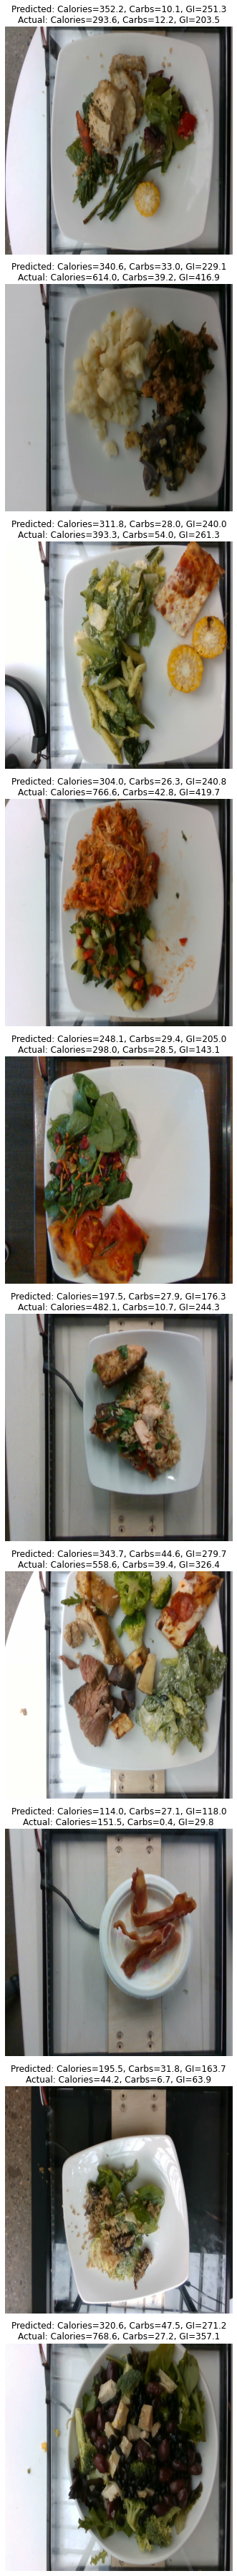

In [59]:
# Function to plot predictions vs actual labels
def plot_images_with_predictions(df, model, yolo_model, img_size=YOLO_IMG_SIZE, num_images=10):
    """
    Plot a set of images along with their predicted and actual nutritional values.
    Args:
        df: DataFrame containing the image data and labels.
        model: Trained TensorFlow regression model.
        yolo_model: YOLO model for feature extraction.
        img_size: Image size for preprocessing.
        num_images: Number of images to plot.
    """
    plt.figure(figsize=(20, num_images * 5))
    
    for i in range(num_images):
        # Select a random sample
        sample_row = df.sample(1).iloc[0]
        image = sample_row['image'].resize((img_size, img_size))  # Resize the image
        image_np = np.array(image)  # Convert to NumPy array
        
        # Extract YOLO features
        features = extract_yolo_features(image_np, yolo_model)
        features = np.expand_dims(features, axis=0)  # Add batch dimension
        
        # Make predictions
        prediction = model.predict(features)
        denormalized_predicted = [
            prediction[0][0] * max_calories,
            prediction[0][1] * max_carb,
            prediction[0][2] * max_gi
        ]
        
        # Denormalize actual labels
        actual_labels = sample_row['label_tensor']
        denormalized_actual = [
            actual_labels[0] * max_calories,
            actual_labels[1] * max_carb,
            actual_labels[2] * max_gi
        ]
        
        # Plot the image
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(
            f"Predicted: Calories={denormalized_predicted[0]:.1f}, "
            f"Carbs={denormalized_predicted[1]:.1f}, GI={denormalized_predicted[2]:.1f}\n"
            f"Actual: Calories={denormalized_actual[0]:.1f}, "
            f"Carbs={denormalized_actual[1]:.1f}, GI={denormalized_actual[2]:.1f}",
            fontsize=12
        )
    
    plt.tight_layout()
    plt.show()

# Plot 10 images with predictions
plot_images_with_predictions(small_train_df, model, yolo_model, num_images=10)


In [57]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.4.1+cu121


# Experimenting with a vision Transformer model

Preprocessing Small Train Data...


Extracting ViT Features: 100%|██████████| 1467/1467 [02:33<00:00,  9.55it/s]


Preprocessing Small Validation Data...


Extracting ViT Features: 100%|██████████| 164/164 [00:18<00:00,  8.78it/s]

Epoch 1/10


184/184 [==============================] - 1s 1ms/step - loss: 0.6361 - mae: 0.4853 - val_loss: 0.3420 - val_mae: 0.3817
Epoch 2/10
184/184 [==============================] - 0s 981us/step - loss: 0.2571 - mae: 0.3134 - val_loss: 0.2334 - val_mae: 0.3098
Epoch 3/10
184/184 [==============================] - 0s 966us/step - loss: 0.1821 - mae: 0.2651 - val_loss: 0.1965 - val_mae: 0.2794
Epoch 4/10
184/184 [==============================] - 0s 969us/step - loss: 0.1457 - mae: 0.2354 - val_loss: 0.1752 - val_mae: 0.2642
Epoch 5/10
184/184 [==============================] - 0s 974us/step - loss: 0.1240 - mae: 0.2203 - val_loss: 0.1598 - val_mae: 0.2462
Epoch 6/10
184/184 [==============================] - 0s 968us/step - loss: 0.1071 - mae: 0.2046 - val_loss: 0.1578 - val_mae: 0.2379
Epoch 7/10
184/184 [==============================] - 0s 982us/step - loss: 0.0954 - mae: 0.1941 - val_loss: 0.1488 - val_mae: 0.2311
Epoch 8/10
184/184 [==============================] - 0s 971us/step - loss:

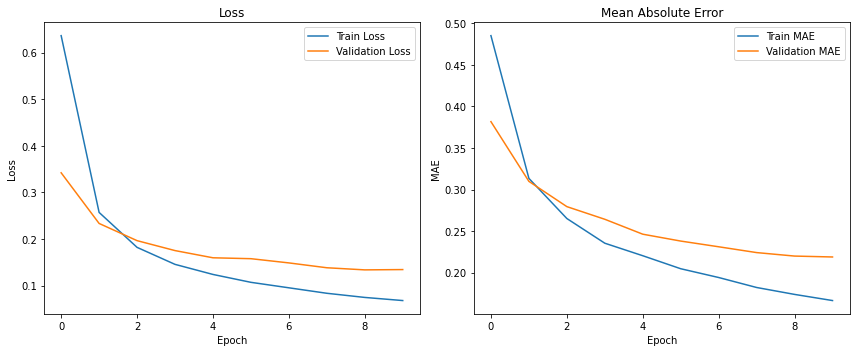

1/1 [==============================] - 0s 32ms/step
Predicted Labels (Transformer): [    0.95231       0.407      3.3791]
Actual Labels: [0.8166788340000001, 0.33701878, 3.28776123046875]
Denormalized Predicted Labels (Transformer): [476.155549287796, 40.6998872756958, 337.90879249572754]
Denormalized Actual Labels: [408.339417, 33.701878, 328.776123046875]


/home/dina/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from transformers import ViTImageProcessor, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt




# Constants
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 0.0001
TF_IMG_SIZE = 224    # Input size for Vision Transformer
max_calories = 500
max_carb = 100
max_gi = 100

# Normalize the labels
df_image_data['label_tensor'] = df_image_data['label_info'].apply(
    lambda x: [
        x['total_calories'] / max_calories,
        x['total_carb'] / max_carb,
        x['GI'] / max_gi
    ]
)

# Split data into train and validation sets
train_df, val_df = train_test_split(df_image_data, test_size=0.1, random_state=42)

# Load Vision Transformer and image processor
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Preprocessing function for ViT
def preprocess_with_vit(df, processor, model, img_size=TF_IMG_SIZE):
    features = []
    labels = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting ViT Features"):
        # Resize image and preprocess
        image = row['image'].resize((img_size, img_size))
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        # Pass through ViT model
        with torch.no_grad():
            feature = model(pixel_values).last_hidden_state.squeeze(0).numpy()
        # Global average pooling
        pooled_feature = np.mean(feature, axis=0)
        features.append(pooled_feature)
        labels.append(row['label_tensor'])
    return np.array(features), np.array(labels)

# Use 50% of the data for faster training and testing
small_train_df = train_df.sample(frac=0.5, random_state=42)
small_val_df = val_df.sample(frac=0.5, random_state=42)

# Preprocess the datasets
print("Preprocessing Small Train Data...")
X_train_small, y_train_small = preprocess_with_vit(small_train_df, image_processor, vit_model)

print("Preprocessing Small Validation Data...")
X_val_small, y_val_small = preprocess_with_vit(small_val_df, image_processor, vit_model)

# Build TensorFlow regression model
def build_transformer_model(input_shape, num_outputs=3):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_outputs)(x)
    return Model(inputs, outputs)

# Create and compile the TensorFlow model
input_shape = X_train_small.shape[1:]  # Shape of ViT features
transformer_model = build_transformer_model(input_shape)
transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])

# Train the transformer model
history = transformer_model.fit(
    X_train_small, y_train_small,
    validation_data=(X_val_small, y_val_small),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Plot the training performance
def plot_training_performance(history):
    plt.figure(figsize=(12, 5))
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Mean Absolute Error Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_performance(history)

# Save the transformer model
transformer_model.save("transformer_nutrition_model.h5")

# Predict on a single image
sample_image = small_train_df.iloc[0]['image']
sample_image = sample_image.resize((TF_IMG_SIZE, TF_IMG_SIZE))  # Resize for ViT
sample_pixel_values = image_processor(images=sample_image, return_tensors="pt").pixel_values
with torch.no_grad():
    sample_feature = vit_model(sample_pixel_values).last_hidden_state.squeeze(0).numpy()
pooled_feature = np.mean(sample_feature, axis=0)

# Predict using the trained transformer model
pooled_feature = np.expand_dims(pooled_feature, axis=0)  # Add batch dimension
transformer_prediction = transformer_model.predict(pooled_feature)
print(f"Predicted Labels (Transformer): {transformer_prediction[0]}")
print(f"Actual Labels: {small_train_df.iloc[0]['label_tensor']}")

# Denormalize predicted and actual labels
transformer_predicted_labels = [
    transformer_prediction[0][0] * max_calories,
    transformer_prediction[0][1] * max_carb,
    transformer_prediction[0][2] * max_gi
]

normalized_actual_labels = small_train_df.iloc[0]['label_tensor']
denormalized_actual_labels = [
    normalized_actual_labels[0] * max_calories,
    normalized_actual_labels[1] * max_carb,
    normalized_actual_labels[2] * max_gi
]

print(f"Denormalized Predicted Labels (Transformer): {transformer_predicted_labels}")
print(f"Denormalized Actual Labels: {denormalized_actual_labels}")



# Yolov8 has higher accuracy than ViT. Next, we focus on HyperParameter Opt for the Yolov8 model

In [62]:
# we define learning rate schedule
def lr_schedule(epoch, lr):
    """
    Exponential decay learning rate scheduler.
    """
    decay_rate = 0.96
    decay_step = 5
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

# we implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# we define variables to store the best model's data
best_val_loss = float('inf')
best_history = None
best_params = {}

# the hyperparameter grid
batch_sizes = [8, 16]
learning_rates = [ 0.0005, 0.0003, 0.0001]
hidden_layer_units = [(128, 64), (256, 128), (256, 128, 64),(512, 256, 128)]

In [63]:
YOLO_IMG_SIZE = 640  # Input size for YOLOv8
TF_IMG_SIZE = 224    # Input size for TensorFlow regression model

In [64]:
# we set the max values for the labels
max_calories = 500  # Replace with the maximum value for calories in your dataset
max_carb = 100      # Replace with the maximum value for carbs
max_gi = 100        # Replace with the maximum value for GI


In [65]:
# we normalize the labels
df_image_data_norm=df_image_data
df_image_data_norm['label_tensor'] = df_image_data['label_info'].apply(
    lambda x: [
        x['total_calories'] / max_calories,
        x['total_carb'] / max_carb,
        x['GI'] / max_gi
    ]
)

# then split data into train and validation sets
train_df, val_df = train_test_split(df_image_data_norm, test_size=0.1, random_state=42)

In [66]:
# we load YOLOv8 model because it is a small model
yolo_model = YOLO("yolov8s.pt")  

In [67]:
# we define a function to plot the training performance
def plot_training_performance(history):
    # Extract training history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mae']
    val_mae = history.history['val_mae']

    # then plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # and plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(mae, label='Training MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.title('MAE During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.show()

In [68]:
# Use 50% of the data instead of 10% of the data for quick testing
small_train_df = train_df.sample(frac=0.5, random_state=42)
small_val_df = val_df.sample(frac=0.5,  random_state=42)

# Preprocess the smaller datasets
print("Preprocessing Small Train Data...")
X_train_small, y_train_small = preprocess_with_yolo(small_train_df, yolo_model)

print("Preprocessing Small Validation Data...")
X_val_small, y_val_small = preprocess_with_yolo(small_val_df, yolo_model)

Preprocessing Small Train Data...


Extracting YOLO Features: 100%|█████████████| 1467/1467 [01:26<00:00, 16.93it/s]


Preprocessing Small Validation Data...


Extracting YOLO Features: 100%|███████████████| 164/164 [00:09<00:00, 16.63it/s]


In [69]:
for batch_size in batch_sizes:
    for lr in learning_rates:
        for units in hidden_layer_units:
            print(f"Testing: Batch Size={batch_size}, Learning Rate={lr}, Units={units}")
            
            # Build the model
            def build_model(input_shape, num_outputs=3):
                inputs = tf.keras.Input(shape=input_shape)
                x = tf.keras.layers.Dense(units[0], activation='relu')(inputs)
                x = tf.keras.layers.Dense(units[1], activation='relu')(x)
                outputs = tf.keras.layers.Dense(num_outputs)(x)
                return tf.keras.Model(inputs, outputs)

            # Rebuild the model with new parameters
            model = build_model(input_shape=X_train_small.shape[1:])
            
            # Compile with the current learning rate
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='mse',
                metrics=['mae']
            )

            # Train the model
            history = model.fit(
                X_train_small, y_train_small,
                validation_data=(X_val_small, y_val_small),
                epochs=50,
                batch_size=batch_size,
                callbacks=[
                    early_stopping, 
                    LearningRateScheduler(lr_schedule)
                ],
                verbose=1
            )

            # Evaluate the model
            val_loss = min(history.history['val_loss'])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {
                    'batch_size': batch_size,
                    'learning_rate': lr,
                    'hidden_layer_units': units
                }
                best_history = history.history
                model.save("best_model.h5")

print("Best Parameters:", best_params)


Testing: Batch Size=8, Learning Rate=0.0005, Units=(128, 64)
Epoch 1/50
184/184 [==============================] - 1s 1ms/step - loss: 0.1977 - mae: 0.2838 - val_loss: 0.1286 - val_mae: 0.2272 - lr: 5.0000e-04
Epoch 2/50
184/184 [==============================] - 0s 978us/step - loss: 0.1232 - mae: 0.2277 - val_loss: 0.1255 - val_mae: 0.2471 - lr: 5.0000e-04
Epoch 3/50
184/184 [==============================] - 0s 900us/step - loss: 0.1076 - mae: 0.2122 - val_loss: 0.1084 - val_mae: 0.2235 - lr: 5.0000e-04
Epoch 4/50
184/184 [==============================] - 0s 892us/step - loss: 0.1010 - mae: 0.2066 - val_loss: 0.1052 - val_mae: 0.2081 - lr: 5.0000e-04
Epoch 5/50
184/184 [==============================] - 0s 916us/step - loss: 0.0938 - mae: 0.2001 - val_loss: 0.0956 - val_mae: 0.1953 - lr: 5.0000e-04
Epoch 6/50
184/184 [==============================] - 0s 955us/step - loss: 0.0811 - mae: 0.1864 - val_loss: 0.0894 - val_mae: 0.1903 - lr: 4.8000e-04
Epoch 7/50
184/184 [===============

/home/dina/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


184/184 [==============================] - 1s 2ms/step - loss: 0.1967 - mae: 0.2818 - val_loss: 0.1595 - val_mae: 0.2406 - lr: 5.0000e-04
Epoch 2/50
184/184 [==============================] - 0s 1ms/step - loss: 0.1188 - mae: 0.2235 - val_loss: 0.1025 - val_mae: 0.2068 - lr: 5.0000e-04
Epoch 3/50
184/184 [==============================] - 0s 1ms/step - loss: 0.1054 - mae: 0.2096 - val_loss: 0.0972 - val_mae: 0.1961 - lr: 5.0000e-04
Epoch 4/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0999 - mae: 0.2068 - val_loss: 0.1035 - val_mae: 0.1999 - lr: 5.0000e-04
Epoch 5/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0899 - mae: 0.1951 - val_loss: 0.0957 - val_mae: 0.1937 - lr: 5.0000e-04
Epoch 6/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0879 - mae: 0.1921 - val_loss: 0.0877 - val_mae: 0.1967 - lr: 4.8000e-04
Epoch 7/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0794 - mae: 0.1839 - val_loss: 0.0984 - v

Epoch 4/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0328 - mae: 0.1280 - val_loss: 0.0498 - val_mae: 0.1501 - lr: 3.0000e-04
Epoch 5/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0325 - mae: 0.1264 - val_loss: 0.0513 - val_mae: 0.1805 - lr: 3.0000e-04
Epoch 6/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0297 - mae: 0.1225 - val_loss: 0.0352 - val_mae: 0.1419 - lr: 2.8800e-04
Epoch 7/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0293 - mae: 0.1220 - val_loss: 0.0333 - val_mae: 0.1339 - lr: 2.8800e-04
Epoch 8/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0273 - mae: 0.1168 - val_loss: 0.0305 - val_mae: 0.1219 - lr: 2.8800e-04
Epoch 9/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0254 - mae: 0.1134 - val_loss: 0.0332 - val_mae: 0.1328 - lr: 2.8800e-04
Epoch 10/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0248 - mae: 0.1120 - val_loss

Epoch 20/50
184/184 [==============================] - 0s 878us/step - loss: 0.0239 - mae: 0.1094 - val_loss: 0.0324 - val_mae: 0.1252 - lr: 8.8474e-05
Epoch 21/50
184/184 [==============================] - 0s 870us/step - loss: 0.0238 - mae: 0.1083 - val_loss: 0.0311 - val_mae: 0.1209 - lr: 8.4935e-05
Epoch 22/50
184/184 [==============================] - 0s 864us/step - loss: 0.0236 - mae: 0.1095 - val_loss: 0.0347 - val_mae: 0.1235 - lr: 8.4935e-05
Epoch 23/50
184/184 [==============================] - 0s 877us/step - loss: 0.0231 - mae: 0.1072 - val_loss: 0.0320 - val_mae: 0.1214 - lr: 8.4935e-05
Epoch 24/50
184/184 [==============================] - 0s 870us/step - loss: 0.0227 - mae: 0.1064 - val_loss: 0.0321 - val_mae: 0.1210 - lr: 8.4935e-05
Epoch 25/50
184/184 [==============================] - 0s 877us/step - loss: 0.0224 - mae: 0.1066 - val_loss: 0.0315 - val_mae: 0.1194 - lr: 8.4935e-05
Epoch 26/50
184/184 [==============================] - 0s 879us/step - loss: 0.0216 - ma

Epoch 19/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0209 - mae: 0.1021 - val_loss: 0.0304 - val_mae: 0.1229 - lr: 8.8474e-05
Epoch 20/50
184/184 [==============================] - 0s 1ms/step - loss: 0.0201 - mae: 0.0997 - val_loss: 0.0312 - val_mae: 0.1185 - lr: 8.8474e-05
Testing: Batch Size=8, Learning Rate=0.0001, Units=(512, 256, 128)
Epoch 1/50
184/184 [==============================] - 1s 2ms/step - loss: 0.0766 - mae: 0.1944 - val_loss: 0.0500 - val_mae: 0.1506 - lr: 1.0000e-04
Epoch 2/50
184/184 [==============================] - 0s 2ms/step - loss: 0.0458 - mae: 0.1511 - val_loss: 0.0463 - val_mae: 0.1501 - lr: 1.0000e-04
Epoch 3/50
184/184 [==============================] - 0s 2ms/step - loss: 0.0410 - mae: 0.1417 - val_loss: 0.0391 - val_mae: 0.1300 - lr: 1.0000e-04
Epoch 4/50
184/184 [==============================] - 0s 2ms/step - loss: 0.0347 - mae: 0.1297 - val_loss: 0.0368 - val_mae: 0.1377 - lr: 1.0000e-04
Epoch 5/50
184/184 [=================

Epoch 19/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0193 - mae: 0.0988 - val_loss: 0.0285 - val_mae: 0.1167 - lr: 4.4237e-04
Epoch 20/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0184 - mae: 0.0956 - val_loss: 0.0278 - val_mae: 0.1172 - lr: 4.4237e-04
Epoch 21/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0188 - mae: 0.0975 - val_loss: 0.0288 - val_mae: 0.1193 - lr: 4.2467e-04
Epoch 22/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0170 - mae: 0.0915 - val_loss: 0.0284 - val_mae: 0.1179 - lr: 4.2467e-04
Epoch 23/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0168 - mae: 0.0919 - val_loss: 0.0338 - val_mae: 0.1214 - lr: 4.2467e-04
Epoch 24/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0177 - mae: 0.0954 - val_loss: 0.0292 - val_mae: 0.1168 - lr: 4.2467e-04
Epoch 25/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0157 - mae: 0.0892 - val_loss: 0.0372

92/92 [==============================] - 0s 997us/step - loss: 0.0295 - mae: 0.1204 - val_loss: 0.0347 - val_mae: 0.1305 - lr: 2.8800e-04
Epoch 11/50
92/92 [==============================] - 0s 997us/step - loss: 0.0294 - mae: 0.1207 - val_loss: 0.0342 - val_mae: 0.1254 - lr: 2.7648e-04
Epoch 12/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0280 - mae: 0.1176 - val_loss: 0.0306 - val_mae: 0.1188 - lr: 2.7648e-04
Epoch 13/50
92/92 [==============================] - 0s 983us/step - loss: 0.0278 - mae: 0.1171 - val_loss: 0.0310 - val_mae: 0.1210 - lr: 2.7648e-04
Epoch 14/50
92/92 [==============================] - 0s 997us/step - loss: 0.0261 - mae: 0.1133 - val_loss: 0.0307 - val_mae: 0.1193 - lr: 2.7648e-04
Epoch 15/50
92/92 [==============================] - 0s 995us/step - loss: 0.0267 - mae: 0.1157 - val_loss: 0.0305 - val_mae: 0.1222 - lr: 2.7648e-04
Epoch 16/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0265 - mae: 0.1150 - val_loss: 0.0302 -

92/92 [==============================] - 0s 1ms/step - loss: 0.0224 - mae: 0.1054 - val_loss: 0.0337 - val_mae: 0.1363 - lr: 2.7648e-04
Epoch 15/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0216 - mae: 0.1040 - val_loss: 0.0294 - val_mae: 0.1208 - lr: 2.7648e-04
Epoch 16/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0223 - mae: 0.1066 - val_loss: 0.0335 - val_mae: 0.1203 - lr: 2.6542e-04
Epoch 17/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0198 - mae: 0.0990 - val_loss: 0.0299 - val_mae: 0.1178 - lr: 2.6542e-04
Epoch 18/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0195 - mae: 0.0990 - val_loss: 0.0298 - val_mae: 0.1158 - lr: 2.6542e-04
Testing: Batch Size=16, Learning Rate=0.0003, Units=(512, 256, 128)
Epoch 1/50
92/92 [==============================] - 1s 3ms/step - loss: 0.0709 - mae: 0.1870 - val_loss: 0.0515 - val_mae: 0.1689 - lr: 3.0000e-04
Epoch 2/50
92/92 [==============================] - 0s 2m

92/92 [==============================] - 0s 998us/step - loss: 0.0280 - mae: 0.1176 - val_loss: 0.0328 - val_mae: 0.1312 - lr: 8.4935e-05
Epoch 24/50
92/92 [==============================] - 0s 992us/step - loss: 0.0275 - mae: 0.1170 - val_loss: 0.0319 - val_mae: 0.1230 - lr: 8.4935e-05
Epoch 25/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0275 - mae: 0.1170 - val_loss: 0.0317 - val_mae: 0.1221 - lr: 8.4935e-05
Epoch 26/50
92/92 [==============================] - 0s 995us/step - loss: 0.0266 - mae: 0.1148 - val_loss: 0.0321 - val_mae: 0.1263 - lr: 8.1537e-05
Epoch 27/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0262 - mae: 0.1137 - val_loss: 0.0305 - val_mae: 0.1221 - lr: 8.1537e-05
Epoch 28/50
92/92 [==============================] - 0s 977us/step - loss: 0.0259 - mae: 0.1140 - val_loss: 0.0329 - val_mae: 0.1237 - lr: 8.1537e-05
Epoch 29/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0252 - mae: 0.1123 - val_loss: 0.0301 - v

Epoch 28/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0192 - mae: 0.0969 - val_loss: 0.0284 - val_mae: 0.1148 - lr: 8.1537e-05
Epoch 29/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0196 - mae: 0.0988 - val_loss: 0.0296 - val_mae: 0.1153 - lr: 8.1537e-05
Epoch 30/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0192 - mae: 0.0980 - val_loss: 0.0297 - val_mae: 0.1161 - lr: 8.1537e-05
Testing: Batch Size=16, Learning Rate=0.0001, Units=(256, 128, 64)
Epoch 1/50
92/92 [==============================] - 1s 2ms/step - loss: 0.0989 - mae: 0.2244 - val_loss: 0.0679 - val_mae: 0.1811 - lr: 1.0000e-04
Epoch 2/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0543 - mae: 0.1634 - val_loss: 0.0588 - val_mae: 0.1776 - lr: 1.0000e-04
Epoch 3/50
92/92 [==============================] - 0s 1ms/step - loss: 0.0459 - mae: 0.1502 - val_loss: 0.0528 - val_mae: 0.1715 - lr: 1.0000e-04
Epoch 4/50
92/92 [==============================

92/92 [==============================] - 0s 2ms/step - loss: 0.0222 - mae: 0.1044 - val_loss: 0.0305 - val_mae: 0.1191 - lr: 9.2160e-05
Epoch 15/50
92/92 [==============================] - 0s 2ms/step - loss: 0.0215 - mae: 0.1024 - val_loss: 0.0311 - val_mae: 0.1182 - lr: 9.2160e-05
Epoch 16/50
92/92 [==============================] - 0s 2ms/step - loss: 0.0209 - mae: 0.1022 - val_loss: 0.0312 - val_mae: 0.1194 - lr: 8.8474e-05
Epoch 17/50
92/92 [==============================] - 0s 2ms/step - loss: 0.0203 - mae: 0.1009 - val_loss: 0.0305 - val_mae: 0.1207 - lr: 8.8474e-05
Epoch 18/50
92/92 [==============================] - 0s 2ms/step - loss: 0.0196 - mae: 0.0992 - val_loss: 0.0305 - val_mae: 0.1196 - lr: 8.8474e-05
Best Parameters: {'batch_size': 16, 'learning_rate': 0.0003, 'hidden_layer_units': (512, 256, 128)}


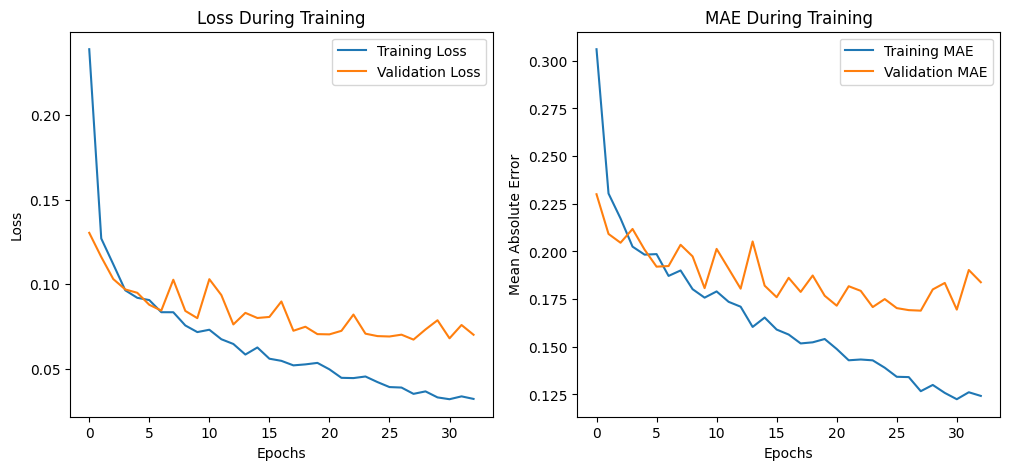

In [70]:
# Convert numpy types to Python native types
def convert_to_serializable(obj):
    if isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
        return obj.item()  # Convert numpy number to Python number
    if isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert numpy array to list
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

# Assuming best_history is a dictionary
try:
    with open("best_model_history.json", "w") as f:
        json.dump(best_history, f, default=convert_to_serializable)
except TypeError as e:
    print(f"Error serializing best_history: {e}")

# Plot training and validation performance
def plot_training_results(history):
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history['mae'], label='Training MAE')
    plt.plot(history['val_mae'], label='Validation MAE')
    plt.title('MAE During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.show()

plot_training_results(best_history)

1/1 [==============================] - 0s 10ms/step


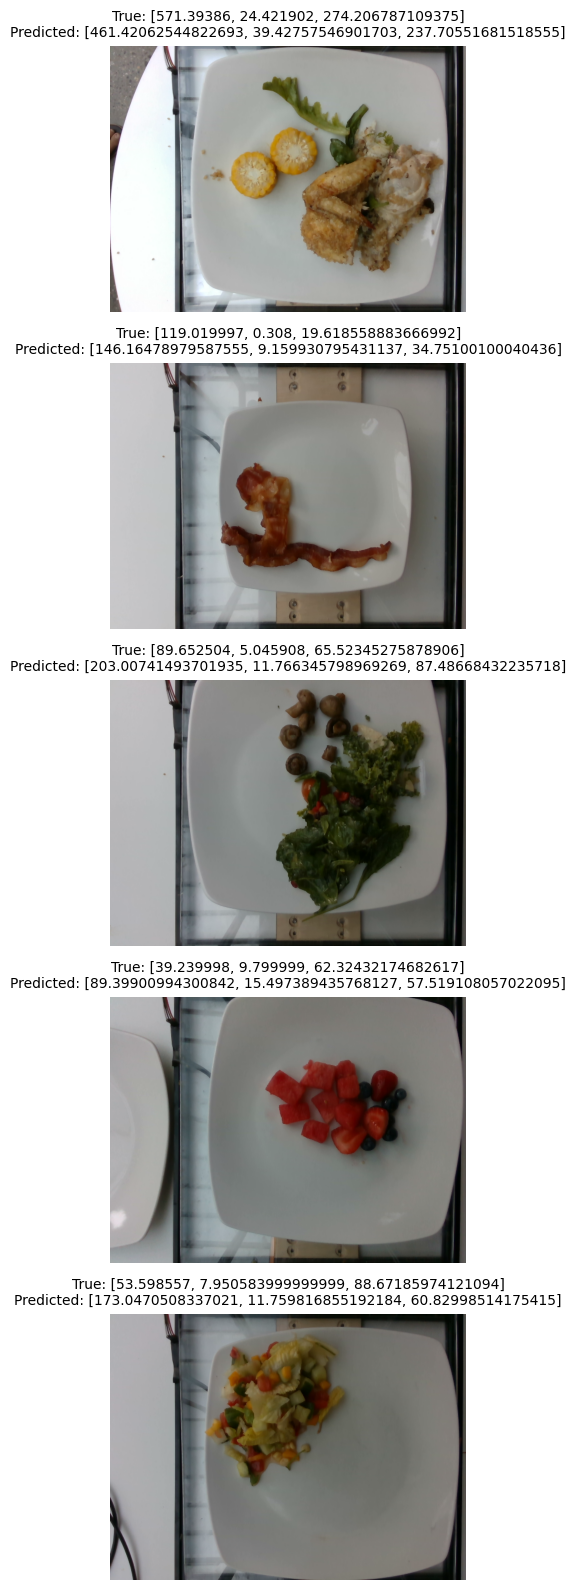

In [71]:
# Visualize sample images with true and predicted values
def visualize_predictions(model, data, num_samples=5):
    fig, axes = plt.subplots(num_samples, 1, figsize=(8, 16))
    for i, ax in enumerate(axes):
        # Select a random sample
        sample_row = data.sample(1).iloc[0]
        image = sample_row['image']
        true_labels = sample_row['label_tensor']

        # Preprocess image for prediction
        sample_image = image.resize((YOLO_IMG_SIZE, YOLO_IMG_SIZE))
        sample_image = np.array(sample_image)
        sample_features = extract_yolo_features(sample_image, yolo_model)
        sample_features = np.expand_dims(sample_features, axis=0)

        # Predict
        prediction = model.predict(sample_features)[0]

        # Denormalize predictions and true labels
        denormalized_prediction = [
            prediction[0] * max_calories,
            prediction[1] * max_carb,
            prediction[2] * max_gi
        ]
        denormalized_true = [
            true_labels[0] * max_calories,
            true_labels[1] * max_carb,
            true_labels[2] * max_gi
        ]

        # Plot the image
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"True: {denormalized_true}\nPredicted: {denormalized_prediction}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(model, small_val_df)


# Given that all insulin pumps mainly uses carbs as an input for nutrition, we will modify the model training to only focus on predicting carbs. The hypothesis is that with predicting a single variable instead of three, the performance can further improve

In [64]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Define learning rate schedule
def lr_schedule(epoch, lr):
    """
    Exponential decay learning rate scheduler.
    """
    decay_rate = 0.96
    decay_step = 5
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Variables to store the best model's data
best_val_loss = float('inf')
best_history = None
best_params = {}

# Hyperparameter grid
batch_sizes = [8, 16]
learning_rates = [ 0.0005, 0.0003, 0.0001]
hidden_layer_units = [(128, 64), (256, 128), (256, 128, 64),(512, 256, 128)]
# Constants

YOLO_IMG_SIZE = 640  # Input size for YOLOv8
TF_IMG_SIZE = 224    # Input size for TensorFlow regression model
# Normalize the carbohydrate label
max_carb = 100      # Replace with the maximum value for carbs
df_image_data_norm = df_image_data
df_image_data_norm['label_tensor'] = df_image_data['label_info'].apply(
    lambda x: x['total_carb'] / max_carb  # Only normalize total_carb
)

# Split data into train and validation sets
train_df, val_df = train_test_split(df_image_data_norm, test_size=0.1, random_state=42)
# Use 50% of the data instead of 10% of the data for quick testing
small_train_df = train_df.sample(frac=0.9, random_state=42)
small_val_df = val_df.sample(frac=0.9,  random_state=42)

# Preprocess the smaller datasets
print("Preprocessing Small Train Data...")
X_train_small, y_train_small = preprocess_with_yolo(small_train_df, yolo_model)

print("Preprocessing Small Validation Data...")
X_val_small, y_val_small = preprocess_with_yolo(small_val_df, yolo_model)

# Ensure labels are reshaped for single output
y_train_small = y_train_small.reshape(-1, 1)  # Single output for carbs
y_val_small = y_val_small.reshape(-1, 1)

# Adjust the build_model function for single output
def build_model(input_shape, num_outputs=1):  # Single output for carbs
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Dense(units[0], activation='relu')(inputs)
    x = tf.keras.layers.Dense(units[1], activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_outputs)(x)  # Single output node
    return tf.keras.Model(inputs, outputs)

# Training loop (unchanged logic, but focused on single output)
for batch_size in batch_sizes:
    for lr in learning_rates:
        for units in hidden_layer_units:
            print(f"Testing: Batch Size={batch_size}, Learning Rate={lr}, Units={units}")
            
            # Build the model
            model = build_model(input_shape=X_train_small.shape[1:])
            
            # Compile with the current learning rate
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss='mse',
                metrics=['mae']
            )

            # Train the model
            history = model.fit(
                X_train_small, y_train_small,
                validation_data=(X_val_small, y_val_small),
                epochs=50,
                batch_size=batch_size,
                callbacks=[
                    early_stopping, 
                    LearningRateScheduler(lr_schedule)
                ],
                verbose=1
            )

            # Evaluate the model
            val_loss = min(history.history['val_loss'])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {
                    'batch_size': batch_size,
                    'learning_rate': lr,
                    'hidden_layer_units': units
                }
                best_history = history.history
                model.save("best_model.h5")

print("Best Parameters:", best_params)



# Visualize sample predictions
#visualize_predictions(model, small_val_df)


Preprocessing Small Train Data...


Extracting YOLO Features: 100%|█████████████| 2641/2641 [02:32<00:00, 17.31it/s]


Preprocessing Small Validation Data...


Extracting YOLO Features: 100%|███████████████| 294/294 [00:16<00:00, 17.46it/s]

Testing: Batch Size=8, Learning Rate=0.0005, Units=(128, 64)
Epoch 1/50


331/331 [==============================] - 1s 1ms/step - loss: 0.0464 - mae: 0.1109 - val_loss: 0.0158 - val_mae: 0.0890 - lr: 5.0000e-04
Epoch 2/50
331/331 [==============================] - 0s 847us/step - loss: 0.0424 - mae: 0.0982 - val_loss: 0.0143 - val_mae: 0.0883 - lr: 5.0000e-04
Epoch 3/50
331/331 [==============================] - 0s 844us/step - loss: 0.0405 - mae: 0.0933 - val_loss: 0.0142 - val_mae: 0.0875 - lr: 5.0000e-04
Epoch 4/50
331/331 [==============================] - 0s 827us/step - loss: 0.0407 - mae: 0.0947 - val_loss: 0.0209 - val_mae: 0.1001 - lr: 5.0000e-04
Epoch 5/50
331/331 [==============================] - 0s 846us/step - loss: 0.0406 - mae: 0.0937 - val_loss: 0.0156 - val_mae: 0.0943 - lr: 5.0000e-04
Epoch 6/50
331/331 [==============================] - 0s 839us/step - loss: 0.0390 - mae: 0.0898 - val_loss: 0.0137 - val_mae: 0.0829 - lr: 4.8000e-04
Epoch 7/50
331/331 [==============================] - 0s 825us/step - loss: 0.0378 - mae: 0.0841 - val_loss

/home/dina/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


331/331 [==============================] - 1s 1ms/step - loss: 0.0473 - mae: 0.1121 - val_loss: 0.0153 - val_mae: 0.0945 - lr: 5.0000e-04
Epoch 2/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0423 - mae: 0.0989 - val_loss: 0.0150 - val_mae: 0.0883 - lr: 5.0000e-04
Epoch 3/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0410 - mae: 0.0932 - val_loss: 0.0146 - val_mae: 0.0864 - lr: 5.0000e-04
Epoch 4/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0400 - mae: 0.0909 - val_loss: 0.0151 - val_mae: 0.1013 - lr: 5.0000e-04
Epoch 5/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0398 - mae: 0.0905 - val_loss: 0.0148 - val_mae: 0.0946 - lr: 5.0000e-04
Epoch 6/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0390 - mae: 0.0884 - val_loss: 0.0126 - val_mae: 0.0844 - lr: 4.8000e-04
Epoch 7/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0378 - mae: 0.0866 - val_loss: 0.0125 - v

331/331 [==============================] - 0s 820us/step - loss: 0.0361 - mae: 0.0798 - val_loss: 0.0122 - val_mae: 0.0788 - lr: 9.6000e-05
Epoch 10/50
331/331 [==============================] - 0s 824us/step - loss: 0.0355 - mae: 0.0781 - val_loss: 0.0127 - val_mae: 0.0865 - lr: 9.6000e-05
Epoch 11/50
331/331 [==============================] - 0s 811us/step - loss: 0.0357 - mae: 0.0796 - val_loss: 0.0119 - val_mae: 0.0798 - lr: 9.2160e-05
Epoch 12/50
331/331 [==============================] - 0s 813us/step - loss: 0.0353 - mae: 0.0779 - val_loss: 0.0115 - val_mae: 0.0804 - lr: 9.2160e-05
Epoch 13/50
331/331 [==============================] - 0s 804us/step - loss: 0.0347 - mae: 0.0756 - val_loss: 0.0114 - val_mae: 0.0779 - lr: 9.2160e-05
Epoch 14/50
331/331 [==============================] - 0s 806us/step - loss: 0.0345 - mae: 0.0751 - val_loss: 0.0110 - val_mae: 0.0781 - lr: 9.2160e-05
Epoch 15/50
331/331 [==============================] - 0s 811us/step - loss: 0.0340 - mae: 0.0742 - 

Epoch 12/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0337 - mae: 0.0757 - val_loss: 0.0109 - val_mae: 0.0773 - lr: 9.2160e-05
Epoch 13/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0339 - mae: 0.0762 - val_loss: 0.0105 - val_mae: 0.0771 - lr: 9.2160e-05
Epoch 14/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0329 - mae: 0.0726 - val_loss: 0.0187 - val_mae: 0.1035 - lr: 9.2160e-05
Epoch 15/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0328 - mae: 0.0749 - val_loss: 0.0120 - val_mae: 0.0785 - lr: 9.2160e-05
Epoch 16/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0321 - mae: 0.0726 - val_loss: 0.0102 - val_mae: 0.0730 - lr: 8.8474e-05
Epoch 17/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0319 - mae: 0.0706 - val_loss: 0.0117 - val_mae: 0.0785 - lr: 8.8474e-05
Epoch 18/50
331/331 [==============================] - 0s 1ms/step - loss: 0.0317 - mae: 0.0707 - va

166/166 [==============================] - 1s 2ms/step - loss: 0.0454 - mae: 0.1089 - val_loss: 0.0161 - val_mae: 0.0951 - lr: 5.0000e-04
Epoch 2/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0412 - mae: 0.0957 - val_loss: 0.0133 - val_mae: 0.0874 - lr: 5.0000e-04
Epoch 3/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0399 - mae: 0.0922 - val_loss: 0.0140 - val_mae: 0.0830 - lr: 5.0000e-04
Epoch 4/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0383 - mae: 0.0862 - val_loss: 0.0130 - val_mae: 0.0885 - lr: 5.0000e-04
Epoch 5/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0389 - mae: 0.0877 - val_loss: 0.0147 - val_mae: 0.0895 - lr: 5.0000e-04
Epoch 6/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0385 - mae: 0.0881 - val_loss: 0.0142 - val_mae: 0.0816 - lr: 4.8000e-04
Epoch 7/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0369 - mae: 0.0824 - val_loss: 0.0180 - v

166/166 [==============================] - 0s 1ms/step - loss: 0.0286 - mae: 0.0752 - val_loss: 0.0104 - val_mae: 0.0772 - lr: 3.9138e-04
Epoch 33/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0271 - mae: 0.0703 - val_loss: 0.0212 - val_mae: 0.0997 - lr: 3.9138e-04
Epoch 34/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0276 - mae: 0.0749 - val_loss: 0.0105 - val_mae: 0.0778 - lr: 3.9138e-04
Epoch 35/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0256 - mae: 0.0673 - val_loss: 0.0189 - val_mae: 0.0958 - lr: 3.9138e-04
Epoch 36/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0269 - mae: 0.0789 - val_loss: 0.0117 - val_mae: 0.0792 - lr: 3.7572e-04
Epoch 37/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0241 - mae: 0.0679 - val_loss: 0.0225 - val_mae: 0.1170 - lr: 3.7572e-04
Testing: Batch Size=16, Learning Rate=0.0005, Units=(512, 256, 128)
Epoch 1/50
166/166 [========================

Epoch 24/50
166/166 [==============================] - 0s 884us/step - loss: 0.0322 - mae: 0.0731 - val_loss: 0.0104 - val_mae: 0.0733 - lr: 2.5480e-04
Testing: Batch Size=16, Learning Rate=0.0003, Units=(256, 128)
Epoch 1/50
166/166 [==============================] - 1s 2ms/step - loss: 0.0458 - mae: 0.1092 - val_loss: 0.0170 - val_mae: 0.0915 - lr: 3.0000e-04
Epoch 2/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0386 - mae: 0.0876 - val_loss: 0.0231 - val_mae: 0.1284 - lr: 3.0000e-04
Epoch 3/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0396 - mae: 0.0956 - val_loss: 0.0149 - val_mae: 0.0874 - lr: 3.0000e-04
Epoch 4/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0383 - mae: 0.0869 - val_loss: 0.0134 - val_mae: 0.0841 - lr: 3.0000e-04
Epoch 5/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0380 - mae: 0.0883 - val_loss: 0.0151 - val_mae: 0.0871 - lr: 3.0000e-04
Epoch 6/50
166/166 [====================

166/166 [==============================] - 0s 2ms/step - loss: 0.0336 - mae: 0.0745 - val_loss: 0.0100 - val_mae: 0.0732 - lr: 2.7648e-04
Epoch 14/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0329 - mae: 0.0713 - val_loss: 0.0321 - val_mae: 0.1503 - lr: 2.7648e-04
Epoch 15/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0354 - mae: 0.0826 - val_loss: 0.0102 - val_mae: 0.0759 - lr: 2.7648e-04
Epoch 16/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0324 - mae: 0.0723 - val_loss: 0.0251 - val_mae: 0.1209 - lr: 2.6542e-04
Epoch 17/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0340 - mae: 0.0791 - val_loss: 0.0096 - val_mae: 0.0717 - lr: 2.6542e-04
Epoch 18/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0326 - mae: 0.0760 - val_loss: 0.0106 - val_mae: 0.0733 - lr: 2.6542e-04
Epoch 19/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0322 - mae: 0.0738 - val_loss: 0.01

166/166 [==============================] - 0s 1ms/step - loss: 0.0343 - mae: 0.0776 - val_loss: 0.0110 - val_mae: 0.0759 - lr: 9.2160e-05
Epoch 14/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0332 - mae: 0.0744 - val_loss: 0.0111 - val_mae: 0.0762 - lr: 9.2160e-05
Epoch 15/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0340 - mae: 0.0765 - val_loss: 0.0107 - val_mae: 0.0757 - lr: 9.2160e-05
Epoch 16/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0334 - mae: 0.0756 - val_loss: 0.0117 - val_mae: 0.0864 - lr: 8.8474e-05
Epoch 17/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0324 - mae: 0.0725 - val_loss: 0.0107 - val_mae: 0.0791 - lr: 8.8474e-05
Epoch 18/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0324 - mae: 0.0727 - val_loss: 0.0107 - val_mae: 0.0759 - lr: 8.8474e-05
Epoch 19/50
166/166 [==============================] - 0s 1ms/step - loss: 0.0325 - mae: 0.0731 - val_loss: 0.01

Epoch 3/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0383 - mae: 0.0873 - val_loss: 0.0148 - val_mae: 0.0860 - lr: 1.0000e-04
Epoch 4/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0376 - mae: 0.0853 - val_loss: 0.0121 - val_mae: 0.0804 - lr: 1.0000e-04
Epoch 5/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0368 - mae: 0.0836 - val_loss: 0.0120 - val_mae: 0.0838 - lr: 1.0000e-04
Epoch 6/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0357 - mae: 0.0799 - val_loss: 0.0113 - val_mae: 0.0804 - lr: 9.6000e-05
Epoch 7/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0353 - mae: 0.0797 - val_loss: 0.0122 - val_mae: 0.0881 - lr: 9.6000e-05
Epoch 8/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0352 - mae: 0.0777 - val_loss: 0.0105 - val_mae: 0.0759 - lr: 9.6000e-05
Epoch 9/50
166/166 [==============================] - 0s 2ms/step - loss: 0.0344 - mae: 0.0761 - val_loss:

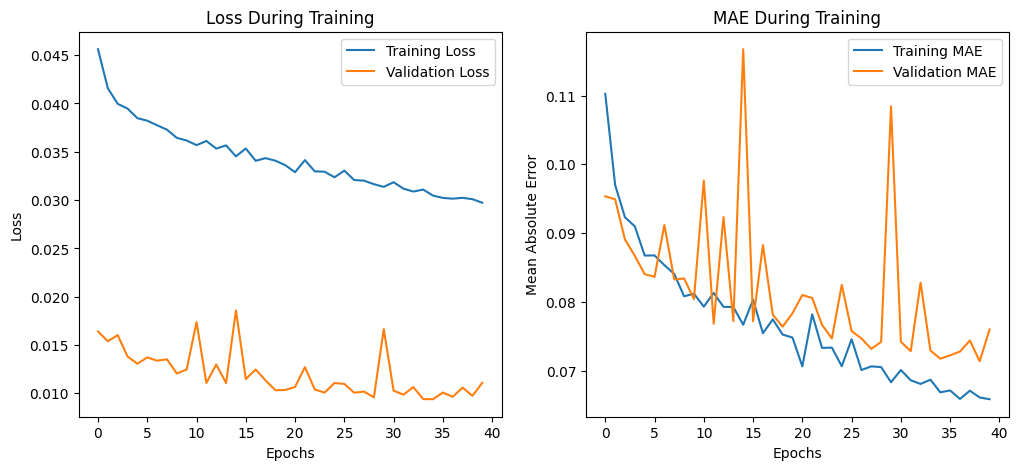

In [65]:
def plot_training_results(history):
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history['mae'], label='Training MAE')
    plt.plot(history['val_mae'], label='Validation MAE')
    plt.title('MAE During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.show()

plot_training_results(best_history)

1/1 [==============================] - 0s 11ms/step


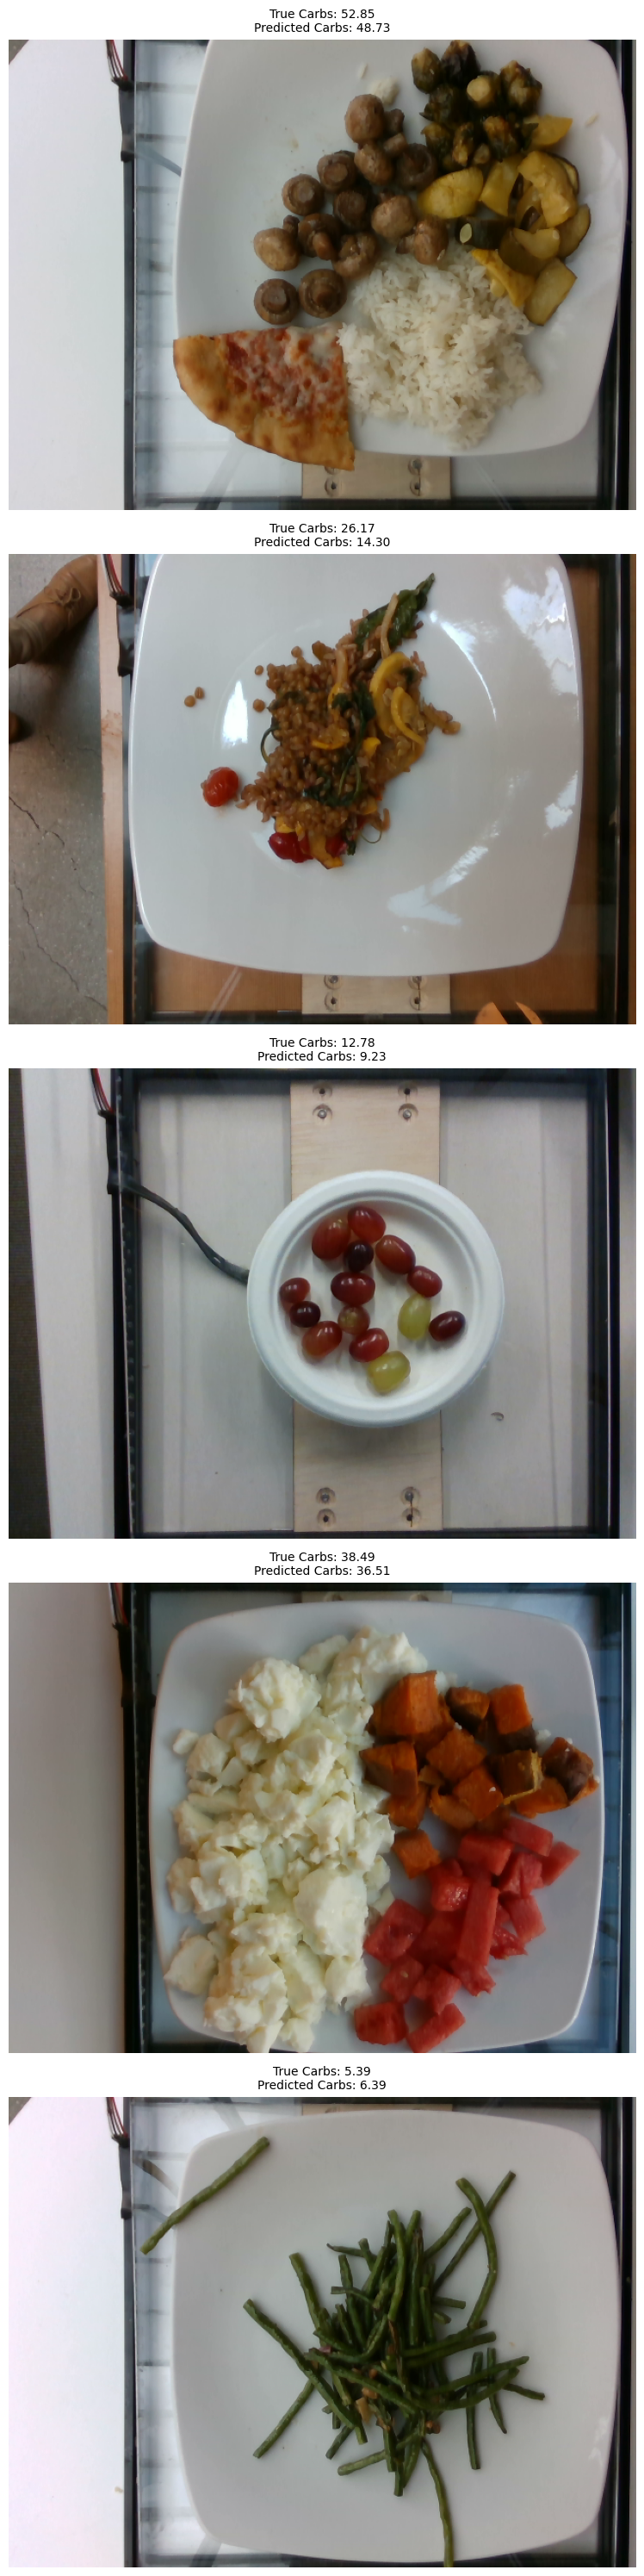

In [66]:
# Visualize predictions (carbs only)
def visualize_predictions(model, data, num_samples=5):
    fig, axes = plt.subplots(num_samples, 1, figsize=(20, 30))
    for i, ax in enumerate(axes):
        # Select a random sample
        sample_row = data.sample(1).iloc[0]
        image = sample_row['image']
        true_label = sample_row['label_tensor']

        # Preprocess image for prediction
        sample_image = image.resize((YOLO_IMG_SIZE, YOLO_IMG_SIZE))
        sample_image = np.array(sample_image)
        sample_features = extract_yolo_features(sample_image, yolo_model)
        sample_features = np.expand_dims(sample_features, axis=0)

        # Predict
        prediction = model.predict(sample_features)[0]

        # Denormalize predictions and true label
        denormalized_prediction = prediction[0] * max_carb
        denormalized_true = true_label * max_carb

        # Plot the image
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"True Carbs: {denormalized_true:.2f}\nPredicted Carbs: {denormalized_prediction:.2f}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(model, small_val_df)

1/1 [==============================] - 0s 16ms/step


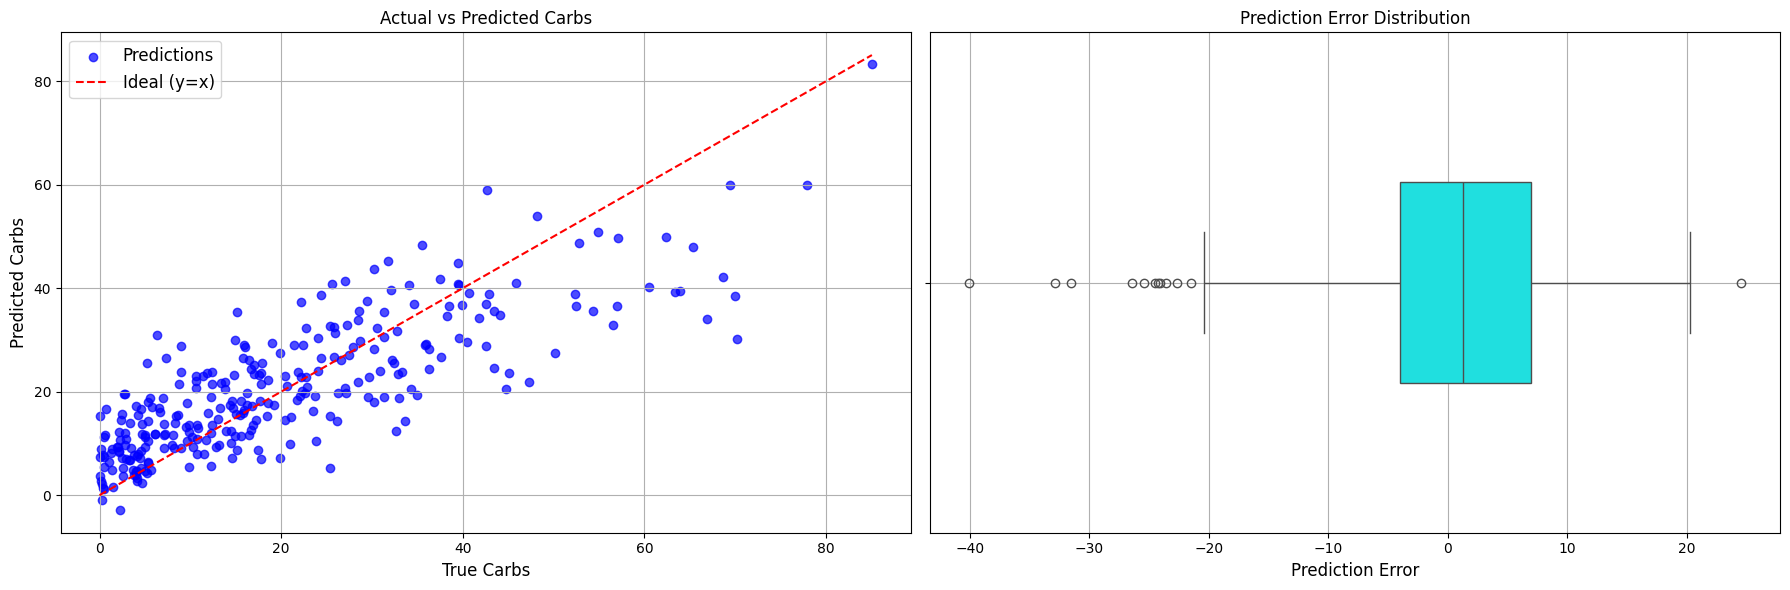

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def visualize_predictions_with_stats_side_by_side(model, data):
    true_values = []
    predicted_values = []
    errors = []

    # Iterate through data to collect true and predicted values
    for _, sample_row in data.iterrows():
        true_label = sample_row['label_tensor']
        image = sample_row['image']

        # Preprocess image for prediction
        sample_image = image.resize((YOLO_IMG_SIZE, YOLO_IMG_SIZE))
        sample_image = np.array(sample_image)
        sample_features = extract_yolo_features(sample_image, yolo_model)
        sample_features = np.expand_dims(sample_features, axis=0)

        # Predict
        prediction = model.predict(sample_features)[0]

        # Denormalize predictions and true label
        denormalized_prediction = prediction[0] * max_carb
        denormalized_true = true_label * max_carb

        true_values.append(denormalized_true)
        predicted_values.append(denormalized_prediction)
        errors.append(denormalized_prediction - denormalized_true)

    # Create a figure with side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Scatter Plot with Ideal Line
    ax_scatter = axes[0]
    ax_scatter.scatter(true_values, predicted_values, alpha=0.7, color='blue', label='Predictions')
    ax_scatter.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', label='Ideal (y=x)')
    ax_scatter.set_title('Actual vs Predicted Carbs', fontsize=12)
    ax_scatter.set_xlabel('True Carbs', fontsize=12)
    ax_scatter.set_ylabel('Predicted Carbs', fontsize=12)
    ax_scatter.legend(fontsize=12)
    ax_scatter.grid()

    # Box Plot for Prediction Errors
    ax_box = axes[1]
    sns.boxplot(x=errors, ax=ax_box, color='cyan', width=0.4)
    ax_box.set_title('Prediction Error Distribution', fontsize=12)
    ax_box.set_xlabel('Prediction Error', fontsize=12)
    ax_box.grid()

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    plt.savefig('prediction_analysis_side_by_side.png', dpi=300)

    plt.show()

# Visualize predictions and stats in a single row
visualize_predictions_with_stats_side_by_side(model, small_val_df)

   


1/1 [==============================] - 0s 11ms/step


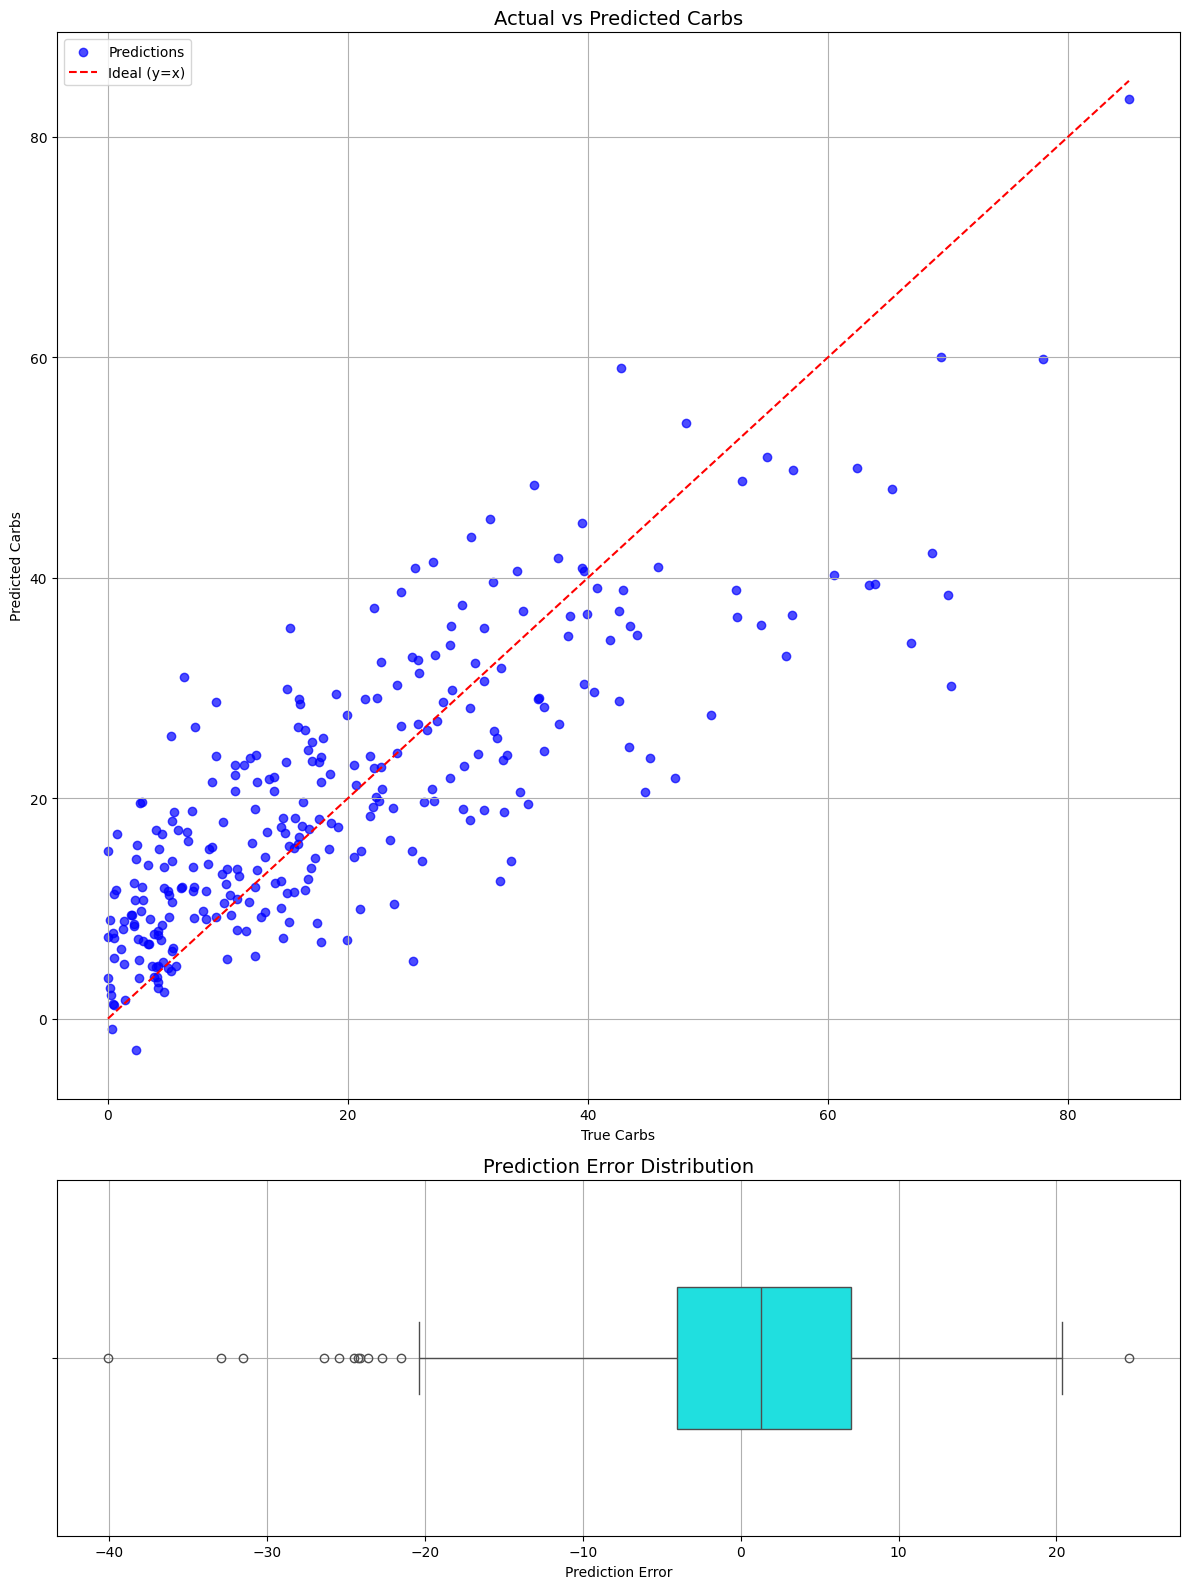

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def visualize_predictions_with_stats(model, data, output_path="prediction_stats.png"):
    true_values = []
    predicted_values = []
    errors = []

    # Iterate through data to collect true and predicted values
    for _, sample_row in data.iterrows():
        true_label = sample_row['label_tensor']
        image = sample_row['image']

        # Preprocess image for prediction
        sample_image = image.resize((YOLO_IMG_SIZE, YOLO_IMG_SIZE))
        sample_image = np.array(sample_image)
        sample_features = extract_yolo_features(sample_image, yolo_model)
        sample_features = np.expand_dims(sample_features, axis=0)
